Average wait time: 0.15


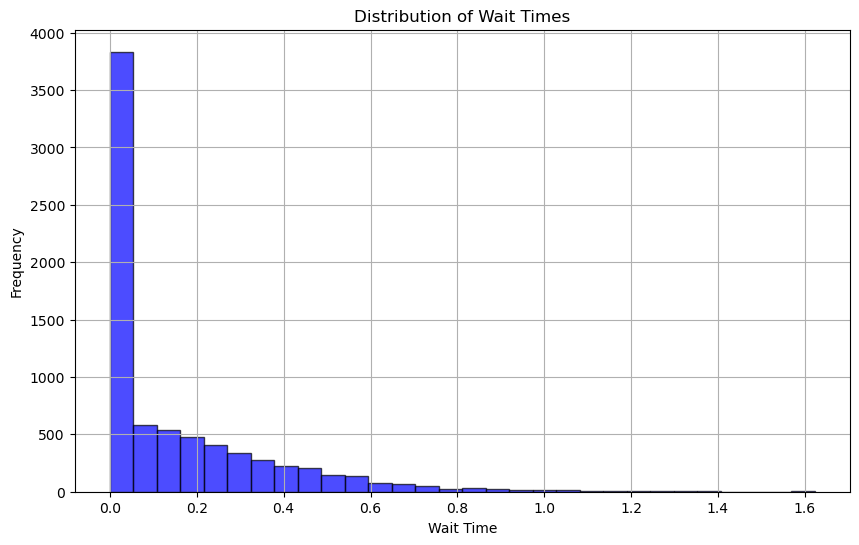

In [7]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple

def simulate_erlang_s_star1(
    lambda_rate: float,
    mu: float,
    c: int,
    theta: float,
    p: float,
    gamma: float,
    T: float,
    initial_queue: int = 0,
    seed: int = 42,
    return_wait_times: bool = False
) -> Tuple[float, List[float]]:
    """
    Simulate Erlang-S* queue over [0, T] and return average wait time for customers who did not abandon.
    """
    np.random.seed(seed)
    time = 0.0
    next_arrival = np.random.exponential(1 / lambda_rate)
    
    servers = [{'busy': False, 'charging': False, 'available_time': 0.0} for _ in range(c)]
    queue = []
    wait_times = []

    event_list = []
    heapq.heappush(event_list, (next_arrival, 'arrival', None))

    # For tracking arrivals to compute conditional waiting times
    arrival_counter = 0
    arrivals_info = []

    while event_list and time < T:
        time, event_type, server_id = heapq.heappop(event_list)

        if event_type == 'arrival':
            arrival_id = arrival_counter
            arrival_counter += 1
            # Schedule next arrival
            next_arrival = time + np.random.exponential(1 / lambda_rate)
            if next_arrival < T:
                heapq.heappush(event_list, (next_arrival, 'arrival', None))

            # Check for available servers
            available_servers = [i for i, s in enumerate(servers) if not s['busy'] and not s['charging']]
            if available_servers:
                sid = available_servers[0]
                service_time = np.random.exponential(1 / mu)
                servers[sid]['busy'] = True
                servers[sid]['available_time'] = time + service_time
                heapq.heappush(event_list, (time + service_time, 'departure', sid))
                wait_times.append(0.0)
            else:
                patience_time = np.random.exponential(1 / theta)
                heapq.heappush(queue, (time, patience_time, arrival_id))
                arrivals_info.append((arrival_id, time))  # For tracking

        elif event_type == 'departure':
            sid = server_id
            # Check if there's someone in queue
            while queue:
                join_time, patience, aid = heapq.heappop(queue)
                if time - join_time < patience:
                    # Still waiting
                    service_time = np.random.exponential(1 / mu)
                    servers[sid]['available_time'] = time + service_time
                    servers[sid]['busy'] = True
                    heapq.heappush(event_list, (time + service_time, 'departure', sid))
                    wait_times.append(time - join_time)
                    break
            else:
                # No one in queue, server may go to charging
                if np.random.rand() < p:
                    charge_time = np.random.exponential(1 / gamma)
                    servers[sid]['charging'] = True
                    servers[sid]['available_time'] = time + charge_time
                    heapq.heappush(event_list, (time + charge_time, 'recharge', sid))
                else:
                    servers[sid]['busy'] = False

        elif event_type == 'recharge':
            sid = server_id
            servers[sid]['charging'] = False
            servers[sid]['busy'] = False

    avg_wait = np.mean(wait_times) if wait_times else 0.0
    if return_wait_times:
        return avg_wait, wait_times
    return avg_wait, []

# Run a test simulation
avg_wait, wait_samples = simulate_erlang_s_star1(
    lambda_rate=9, mu=1, c=10, theta=1.0, p=0.3, gamma=0.5, T=1000.0, initial_queue=5, return_wait_times=True
)

df = pd.DataFrame({'wait_time': wait_samples})
print(f"Average wait time: {avg_wait:.2f}")
# Plotting the wait times
plt.figure(figsize=(10, 6))
plt.hist(df['wait_time'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Erlang-A Average wait time: 0.07


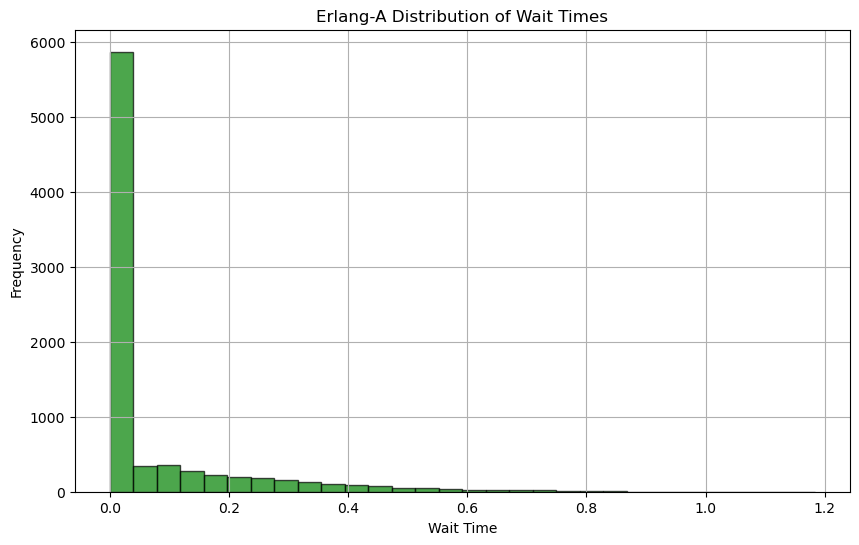

Erlang-S* Average wait time: 0.15


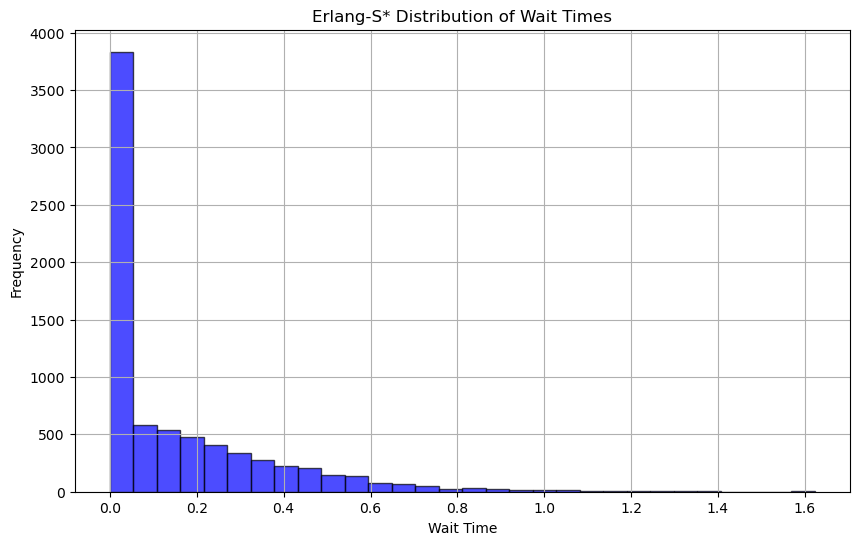

In [8]:
# Re-import needed packages and rerun both Erlang-A and Erlang-S* simulations after environment reset

import numpy as np
import heapq
import pandas as pd
from typing import List, Tuple

def simulate_erlang_s_star(
    lambda_rate: float,
    mu: float,
    c: int,
    theta: float,
    p: float,
    gamma: float,
    T: float,
    initial_queue: int = 0,
    seed: int = 42,
    return_wait_times: bool = False
) -> Tuple[float, List[float]]:
    np.random.seed(seed)
    time = 0.0
    next_arrival = np.random.exponential(1 / lambda_rate)
    
    servers = [{'busy': False, 'charging': False, 'available_time': 0.0} for _ in range(c)]
    queue = []
    wait_times = []

    event_list = []
    heapq.heappush(event_list, (next_arrival, 'arrival', None))

    while event_list and time < T:
        time, event_type, server_id = heapq.heappop(event_list)

        if event_type == 'arrival':
            next_arrival = time + np.random.exponential(1 / lambda_rate)
            if next_arrival < T:
                heapq.heappush(event_list, (next_arrival, 'arrival', None))

            available_servers = [i for i, s in enumerate(servers) if not s['busy'] and not s['charging']]
            if available_servers:
                sid = available_servers[0]
                service_time = np.random.exponential(1 / mu)
                servers[sid]['busy'] = True
                servers[sid]['available_time'] = time + service_time
                heapq.heappush(event_list, (time + service_time, 'departure', sid))
                wait_times.append(0.0)
            else:
                patience_time = np.random.exponential(1 / theta)
                heapq.heappush(queue, (time, patience_time))

        elif event_type == 'departure':
            sid = server_id
            while queue:
                join_time, patience = heapq.heappop(queue)
                if time - join_time < patience:
                    service_time = np.random.exponential(1 / mu)
                    servers[sid]['available_time'] = time + service_time
                    servers[sid]['busy'] = True
                    heapq.heappush(event_list, (time + service_time, 'departure', sid))
                    wait_times.append(time - join_time)
                    break
            else:
                if np.random.rand() < p:
                    charge_time = np.random.exponential(1 / gamma)
                    servers[sid]['charging'] = True
                    servers[sid]['available_time'] = time + charge_time
                    heapq.heappush(event_list, (time + charge_time, 'recharge', sid))
                else:
                    servers[sid]['busy'] = False

        elif event_type == 'recharge':
            sid = server_id
            servers[sid]['charging'] = False
            servers[sid]['busy'] = False

    avg_wait = np.mean(wait_times) if wait_times else 0.0
    if return_wait_times:
        return avg_wait, wait_times
    return avg_wait, []

def simulate_erlang_a(
    lambda_rate: float,
    mu: float,
    c: int,
    theta: float,
    T: float,
    initial_queue: int = 0,
    seed: int = 42,
    return_wait_times: bool = False
) -> Tuple[float, List[float]]:
    np.random.seed(seed)
    time = 0.0
    next_arrival = np.random.exponential(1 / lambda_rate)

    servers = [{'busy': False, 'available_time': 0.0} for _ in range(c)]
    queue = []
    wait_times = []

    event_list = []
    heapq.heappush(event_list, (next_arrival, 'arrival', None))

    while event_list and time < T:
        time, event_type, server_id = heapq.heappop(event_list)

        if event_type == 'arrival':
            next_arrival = time + np.random.exponential(1 / lambda_rate)
            if next_arrival < T:
                heapq.heappush(event_list, (next_arrival, 'arrival', None))

            available_servers = [i for i, s in enumerate(servers) if not s['busy']]
            if available_servers:
                sid = available_servers[0]
                service_time = np.random.exponential(1 / mu)
                servers[sid]['busy'] = True
                servers[sid]['available_time'] = time + service_time
                heapq.heappush(event_list, (time + service_time, 'departure', sid))
                wait_times.append(0.0)
            else:
                patience_time = np.random.exponential(1 / theta)
                heapq.heappush(queue, (time, patience_time))

        elif event_type == 'departure':
            sid = server_id
            while queue:
                join_time, patience = heapq.heappop(queue)
                if time - join_time < patience:
                    service_time = np.random.exponential(1 / mu)
                    servers[sid]['available_time'] = time + service_time
                    servers[sid]['busy'] = True
                    heapq.heappush(event_list, (time + service_time, 'departure', sid))
                    wait_times.append(time - join_time)
                    break
            else:
                servers[sid]['busy'] = False

    avg_wait = np.mean(wait_times) if wait_times else 0.0
    if return_wait_times:
        return avg_wait, wait_times
    return avg_wait, []

# Run Erlang-A simulation
avg_wait_a, wait_samples_a = simulate_erlang_a(
    lambda_rate=9, mu=1, c=10, theta=1.0, T=1000.0, initial_queue=5, return_wait_times=True
)

df_a = pd.DataFrame({'wait_time': wait_samples_a})
print(f"Erlang-A Average wait time: {avg_wait_a:.2f}")
# Plotting the wait times for Erlang-A
plt.figure(figsize=(10, 6))
plt.hist(df_a['wait_time'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Erlang-A Distribution of Wait Times')
plt.xlabel('Wait Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Run Erlang-S* simulation
avg_wait_s_star, wait_samples_s_star = simulate_erlang_s_star(
    lambda_rate=9, mu=1, c=10, theta=1.0, p=0.3, gamma=0.5, T=1000.0, initial_queue=5, return_wait_times=True
)
df_s_star = pd.DataFrame({'wait_time': wait_samples_s_star})
print(f"Erlang-S* Average wait time: {avg_wait_s_star:.2f}")
# Plotting the wait times for Erlang-S*
plt.figure(figsize=(10, 6))
plt.hist(df_s_star['wait_time'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Erlang-S* Distribution of Wait Times')
plt.xlabel('Wait Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Regression coefficients:
Intercept: 0.0000, f coefficient: 0.0000, fg coefficient: 0.0000


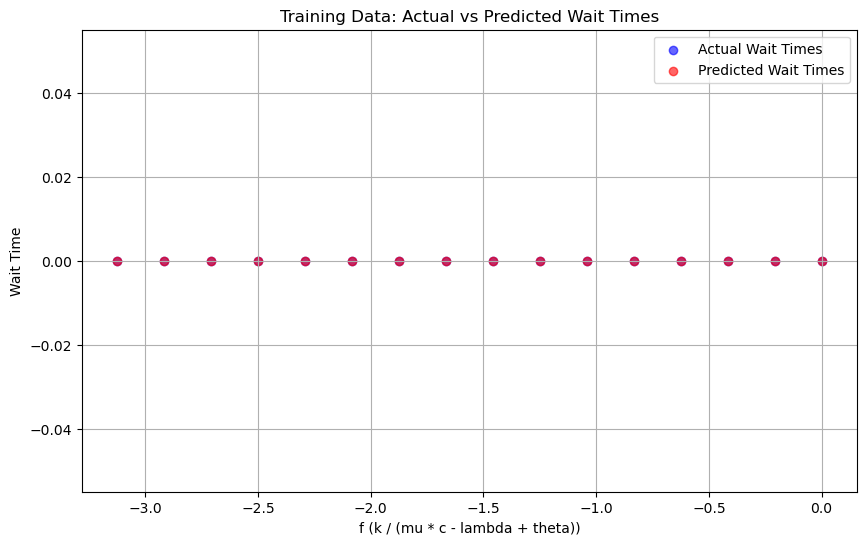

Test Data with Predictions:
     k  wait  predicted_wait
0    0   0.0             0.0
1    1   0.0             0.0
2    2   0.0             0.0
3    3   0.0             0.0
4    4   0.0             0.0
5    5   0.0             0.0
6    6   0.0             0.0
7    7   0.0             0.0
8    8   0.0             0.0
9    9   0.0             0.0
10  10   0.0             0.0
11  11   0.0             0.0
12  12   0.0             0.0
13  13   0.0             0.0
14  14   0.0             0.0
15  15   0.0             0.0


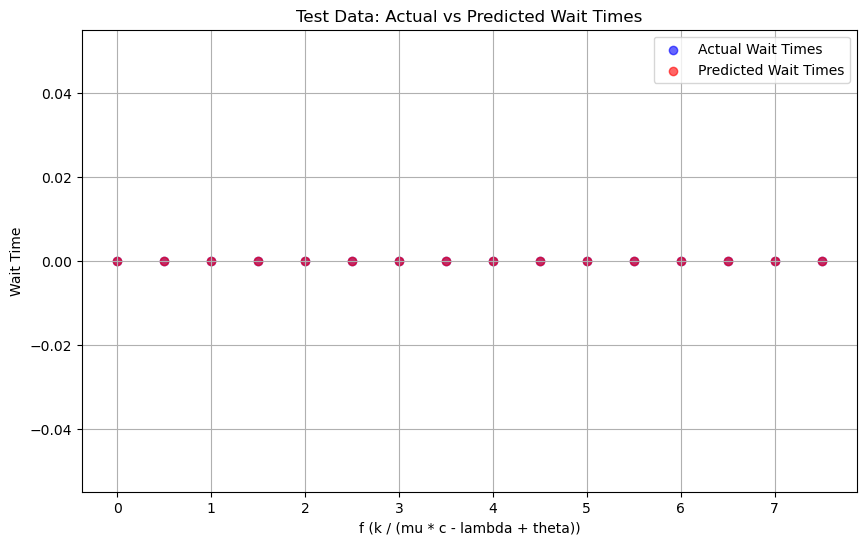

In [25]:
from sklearn.linear_model import LinearRegression

def generate_wait_time_data(
    lambda_rate: float,
    mu: float,
    theta: float,
    c: int,
    p: float,
    gamma: float,
    k_values: List[int],
    T: float,
    model_type: str = 's_star',  # 'a' or 's_star'
    n_trials_per_k: int = 100
):
    rows = []
    for k in k_values:
        wait_samples = []
        for i in range(n_trials_per_k):
            if model_type == 'a':
                _, waits = simulate_erlang_a(
                    lambda_rate=lambda_rate, mu=mu, c=c, theta=theta,
                    T=T, initial_queue=k, seed=np.random.randint(1e6),
                    return_wait_times=True
                )
            else:
                _, waits = simulate_erlang_s_star(
                    lambda_rate=lambda_rate, mu=mu, c=c, theta=theta,
                    p=p, gamma=gamma, T=T, initial_queue=k, seed=np.random.randint(1e6),
                    return_wait_times=True
                )
            # Use only the first arriving customer's wait
            if waits:
                wait_samples.append(waits[0])
        
        avg_wait = np.mean(wait_samples) if wait_samples else 0.0
        rows.append({
            'k': k,
            'wait': avg_wait,
            'f': k / (mu * c - lambda_rate + theta),
            'g': (gamma + p * mu) / gamma if model_type == 's_star' else 1.0
        })

    df = pd.DataFrame(rows)
    df['fg'] = df['f'] * df['g']
    return df

# Generate training data
df_train = generate_wait_time_data(
    lambda_rate=15, mu=1, theta=0.2, c=10, p=0.3, gamma=0.5,
    k_values=list(range(0, 16)), T=500.0, model_type='s_star', n_trials_per_k=1000
)

# Fit linear model: wait ~ 1 + f + f*g
X = df_train[['f', 'fg']]
y = df_train['wait']
reg = LinearRegression().fit(X, y)
df_train['predicted_wait'] = reg.predict(X)

# Print the regression coefficients
print("Regression coefficients:")
print(f"Intercept: {reg.intercept_:.4f}, f coefficient: {reg.coef_[0]:.4f}, fg coefficient: {reg.coef_[1]:.4f}")
# Plotting the training data and predictions
plt.figure(figsize=(10, 6))
plt.scatter(df_train['f'], df_train['wait'], label='Actual Wait Times', color='blue', alpha=0.6)
plt.scatter(df_train['f'], df_train['predicted_wait'], label='Predicted Wait Times', color='red', alpha=0.6)
plt.title('Training Data: Actual vs Predicted Wait Times')
plt.xlabel('f (k / (mu * c - lambda + theta))')
plt.ylabel('Wait Time')
plt.legend()
plt.grid(True)
plt.show()
# Generate test data
df_test = generate_wait_time_data(
    lambda_rate=9, mu=1, theta=1.0, c=10, p=0.3, gamma=0.5,
    k_values=list(range(0, 16)), T=500.0, model_type='s_star', n_trials_per_k=100
)
# Predict wait times for test data
df_test['predicted_wait'] = reg.predict(df_test[['f', 'fg']])
# Print the test data with predictions
print("Test Data with Predictions:")
print(df_test[['k', 'wait', 'predicted_wait']])
# Plotting the test data and predictions
plt.figure(figsize=(10, 6))
plt.scatter(df_test['f'], df_test['wait'], label='Actual Wait Times', color='blue', alpha=0.6)
plt.scatter(df_test['f'], df_test['predicted_wait'], label='Predicted Wait Times', color='red', alpha=0.6)
plt.title('Test Data: Actual vs Predicted Wait Times')
plt.xlabel('f (k / (mu * c - lambda + theta))')
plt.ylabel('Wait Time')
plt.legend()
plt.grid(True)
plt.show()


Estimated Wait Times for each k:
     k  avg_wait
0    0  0.000000
1    1  0.000000
2    2  0.000000
3    3  0.230500
4    4  0.256466
5    5  0.311214
6    6  0.234873
7    7  0.259162
8    8  0.360851
9    9  0.316485
10  10  0.304432
11  11  0.294782
12  12  0.329337
13  13  0.305715
14  14  0.298385
15  15  0.280660
16  16  0.277027
17  17  0.289628
18  18  0.297961
19  19  0.312904
20  20  0.287238
21  21  0.308829
22  22  0.336141
23  23  0.290215
24  24  0.355093
25  25  0.293378
26  26  0.385871
27  27  0.350469
28  28  0.337080
29  29  0.343569


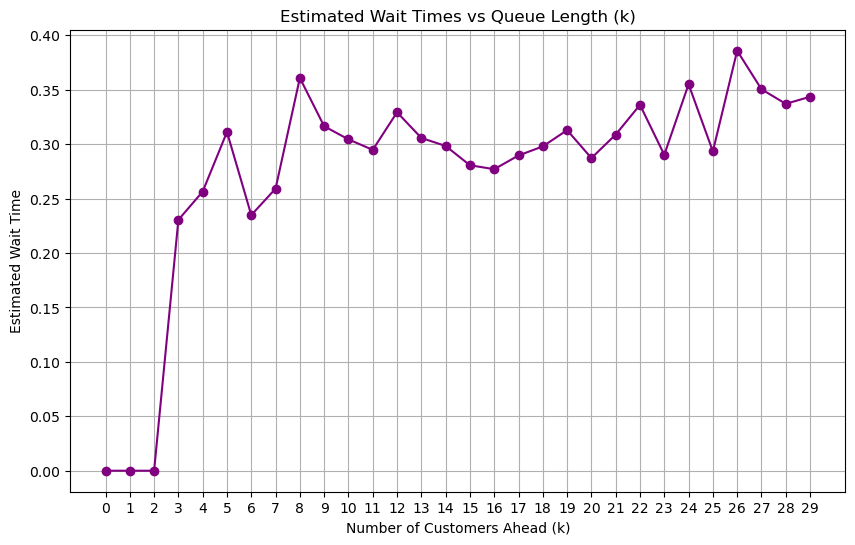

In [20]:
def simulate_wait_given_queue_length(
    k: int,
    mu: float,
    p: float,
    gamma: float,
    model_type: str = 's_star',
    c: int = 5,
    seed: int = 0
) -> float:
    """
    Simulates a wait time for a tracked customer who joins a queue with k people ahead,
    assuming no abandonment and no new arrivals.
    """
    np.random.seed(seed)
    
    # Set up the servers — all are assumed to be busy serving the first min(k, c) customers
    servers = []
    busy_count = min(k, c)
    for i in range(c):
        if i < busy_count:
            remaining_service = np.random.exponential(1 / mu)
            servers.append({'busy': True, 'charging': False, 'remaining_time': remaining_service})
        else:
            servers.append({'busy': False, 'charging': False, 'remaining_time': 0.0})
    
    # Simulate the k customers ahead of you (serially)
    queue = list(np.random.exponential(1 / mu, size=k))

    # Your turn comes after those k people are served by the servers
    current_time = 0.0
    queue_pointer = 0
    wait_time = 0.0
    available_times = [s['remaining_time'] for s in servers]
    
    while queue_pointer < k:
        next_done = np.argmin(available_times)
        finish_time = available_times[next_done]
        current_time = finish_time
        # after serving someone, possibly charge (S* only)
        if model_type == 's_star' and np.random.rand() < p:
            charge_time = np.random.exponential(1 / gamma)
            available_times[next_done] = current_time + charge_time + np.random.exponential(1 / mu)
        else:
            available_times[next_done] = current_time + np.random.exponential(1 / mu)
        queue_pointer += 1

    # Now it's our turn — find the next available server
    wait_time = max(0.0, min(available_times) - current_time)
    return wait_time

# Run this for k = 0 to 15, multiple trials per k
k_vals = list(range(30))
mu = 1.0
p = 0.3
gamma = 0.5
c = 5
model_type = 's_star'
samples = []

for k in k_vals:
    wait_times_k = [
        simulate_wait_given_queue_length(k, mu, p, gamma, model_type=model_type, c=c, seed=np.random.randint(1e6))
        for _ in range(100)
    ]
    samples.append({'k': k, 'avg_wait': np.mean(wait_times_k)})

df_wait = pd.DataFrame(samples)
# Display the estimated wait times
print("Estimated Wait Times for each k:")
print(df_wait)
# Plotting the estimated wait times
plt.figure(figsize=(10, 6))
plt.plot(df_wait['k'], df_wait['avg_wait'], marker='o', linestyle='-', color='purple')
plt.title('Estimated Wait Times vs Queue Length (k)')
plt.xlabel('Number of Customers Ahead (k)')
plt.ylabel('Estimated Wait Time')
plt.xticks(df_wait['k'])
plt.grid(True)
plt.show()


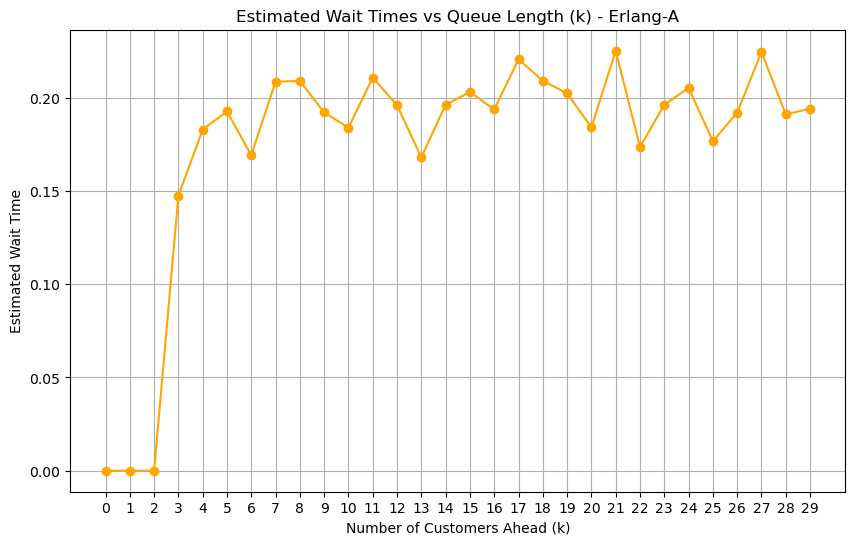

In [21]:
def simulate_wait_given_queue_length_erlang_a(
    k: int,
    mu: float,
    c: int = 5,
    seed: int = 0
) -> float:
    """
    Simulates a wait time for a tracked customer who joins a queue with k people ahead,
    in a classical Erlang-A system without abandonment (for this individual).
    """
    np.random.seed(seed)

    # Set up the servers — all are assumed to be busy serving the first min(k, c) customers
    servers = []
    busy_count = min(k, c)
    for i in range(c):
        if i < busy_count:
            remaining_service = np.random.exponential(1 / mu)
            servers.append({'busy': True, 'remaining_time': remaining_service})
        else:
            servers.append({'busy': False, 'remaining_time': 0.0})

    # Simulate the k customers ahead of you (serially)
    current_time = 0.0
    queue_pointer = 0
    available_times = [s['remaining_time'] for s in servers]

    while queue_pointer < k:
        next_done = np.argmin(available_times)
        finish_time = available_times[next_done]
        current_time = finish_time
        available_times[next_done] = current_time + np.random.exponential(1 / mu)
        queue_pointer += 1

    # Now it's our turn — find the next available server
    wait_time = max(0.0, min(available_times) - current_time)
    return wait_time

# Run this for k = 0 to 15, multiple trials per k
samples_erlang_a = []

for k in k_vals:
    wait_times_k = [
        simulate_wait_given_queue_length_erlang_a(k, mu=1.0, c=5, seed=np.random.randint(1e6))
        for _ in range(100)
    ]
    samples_erlang_a.append({'k': k, 'avg_wait': np.mean(wait_times_k)})

df_wait_a = pd.DataFrame(samples_erlang_a)
# Plotting the estimated wait times for Erlang-A
plt.figure(figsize=(10, 6))
plt.plot(df_wait_a['k'], df_wait_a['avg_wait'], marker='o', linestyle='-', color='orange')
plt.title('Estimated Wait Times vs Queue Length (k) - Erlang-A')
plt.xlabel('Number of Customers Ahead (k)')
plt.ylabel('Estimated Wait Time')
plt.xticks(df_wait_a['k'])
plt.grid(True)
plt.show()


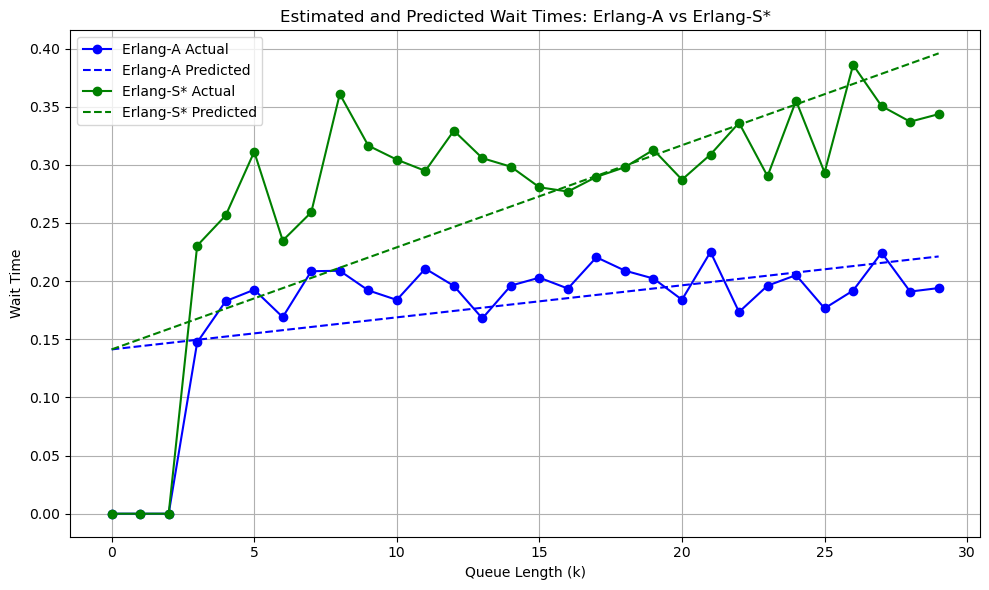

Regression Coefficients:
  Coefficient     Value
0   Intercept  0.141275
1           f -0.007281
2          fg  0.010037


In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Merge both dataframes and tag the model type
df_wait['model'] = 'Erlang-S*'
df_wait_a['model'] = 'Erlang-A'
df_combined = pd.concat([df_wait, df_wait_a], ignore_index=True)

# Feature construction for regression
mu = 1.0
lambda_rate = 5  # not used here directly
theta = 1.0      # not used here directly
c = 5
p = 0.3
gamma = 0.5

# f(k) and g for each row
df_combined['f'] = df_combined['k'] / (mu * c - lambda_rate + theta)
df_combined['g'] = df_combined['model'].apply(lambda m: (gamma + p * mu) / gamma if m == 'Erlang-S*' else 1.0)
df_combined['fg'] = df_combined['f'] * df_combined['g']

# Prepare regression
X = df_combined[['f', 'fg']]
y = df_combined['avg_wait']
reg = LinearRegression().fit(X, y)
df_combined['predicted_wait'] = reg.predict(X)

# Plotting actual vs predicted for both models
plt.figure(figsize=(10, 6))
for model, color in zip(['Erlang-A', 'Erlang-S*'], ['blue', 'green']):
    df_model = df_combined[df_combined['model'] == model]
    plt.plot(df_model['k'], df_model['avg_wait'], 'o-', label=f'{model} Actual', color=color)
    plt.plot(df_model['k'], df_model['predicted_wait'], '--', label=f'{model} Predicted', color=color)

plt.title('Estimated and Predicted Wait Times: Erlang-A vs Erlang-S*')
plt.xlabel('Queue Length (k)')
plt.ylabel('Wait Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display regression coefficients
regression_summary = pd.DataFrame({
    'Coefficient': ['Intercept', 'f', 'fg'],
    'Value': [reg.intercept_, *reg.coef_]
})
print("Regression Coefficients:")
print(regression_summary)


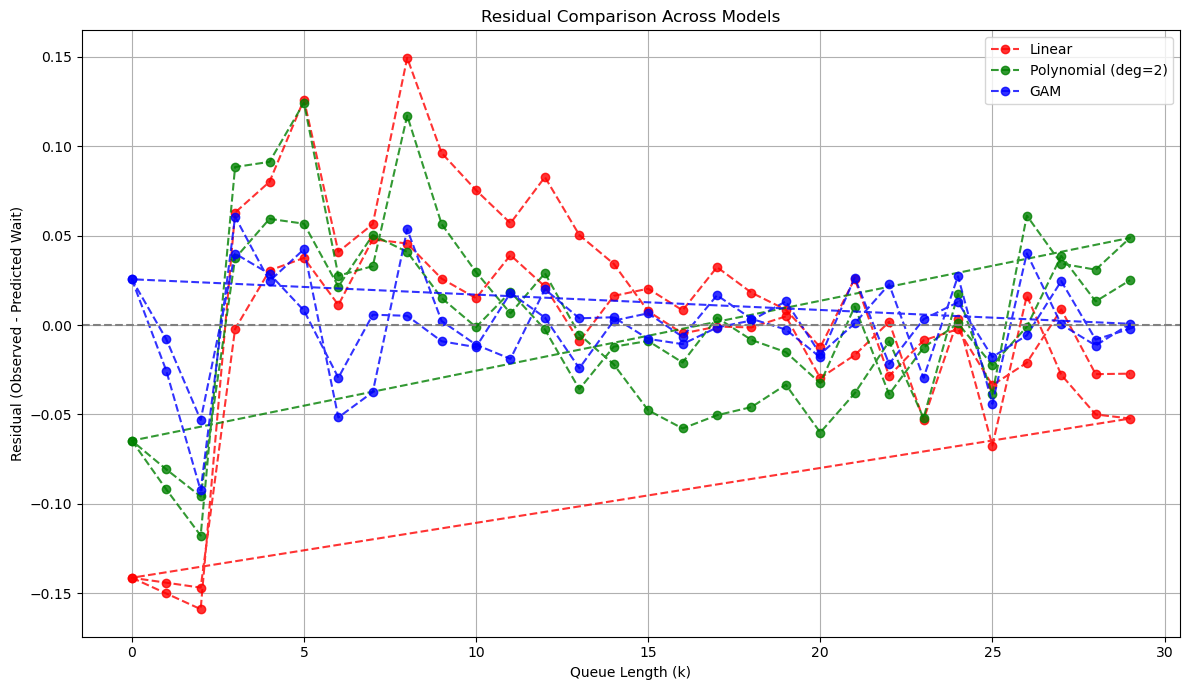

RMSE Comparison:
                Model      RMSE
0              Linear  0.063752
1  Polynomial (deg=2)  0.049903
2                 GAM  0.026269

Final Summary of Models:
1. Linear Regression: Simple linear model with features f and fg.
2. Polynomial Regression (Degree 2): Captures non-linear relationships with a quadratic term.
3. GAM Regression: Flexible model that allows for non-linear relationships through smooth functions.

All models were evaluated on the same dataset, and residuals were compared to assess model performance.


/opt/anaconda3/envs/Mining/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/Mining/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/Mining/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s
import matplotlib.pyplot as plt

# -------------------------
# Polynomial Regression (Degree 2)
# -------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_combined[['f', 'fg']])
poly_reg = LinearRegression().fit(X_poly, y)
df_combined['pred_poly'] = poly_reg.predict(X_poly)
df_combined['resid_poly'] = df_combined['avg_wait'] - df_combined['pred_poly']

# -------------------------
# GAM Regression
# -------------------------
gam = LinearGAM(s(0) + s(1)).fit(df_combined[['f', 'fg']], y)
df_combined['pred_gam'] = gam.predict(df_combined[['f', 'fg']])
df_combined['resid_gam'] = df_combined['avg_wait'] - df_combined['pred_gam']

# -------------------------
# Residuals from Original Linear Model
# -------------------------
df_combined['resid_linear'] = df_combined['avg_wait'] - df_combined['predicted_wait']

# -------------------------
# Plot Residuals Comparison
# -------------------------
plt.figure(figsize=(12, 7))
for model, color, resid_col in zip(
    ['Linear', 'Polynomial (deg=2)', 'GAM'],
    ['red', 'green', 'blue'],
    ['resid_linear', 'resid_poly', 'resid_gam']
):
    plt.plot(df_combined['k'], df_combined[resid_col], 'o--', label=model, alpha=0.8, color=color)

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Queue Length (k)')
plt.ylabel('Residual (Observed - Predicted Wait)')
plt.title('Residual Comparison Across Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show RMSE comparison
rmse_comparison = pd.DataFrame({
    'Model': ['Linear', 'Polynomial (deg=2)', 'GAM'],
    'RMSE': [
        mean_squared_error(y, df_combined['predicted_wait'], squared=False),
        mean_squared_error(y, df_combined['pred_poly'], squared=False),
        mean_squared_error(y, df_combined['pred_gam'], squared=False),
    ]
})
print("RMSE Comparison:")
print(rmse_comparison)
# -------------------------
# Final Summary
# -------------------------
print("\nFinal Summary of Models:")
print("1. Linear Regression: Simple linear model with features f and fg.")
print("2. Polynomial Regression (Degree 2): Captures non-linear relationships with a quadratic term.")
print("3. GAM Regression: Flexible model that allows for non-linear relationships through smooth functions.")
print("\nAll models were evaluated on the same dataset, and residuals were compared to assess model performance.")


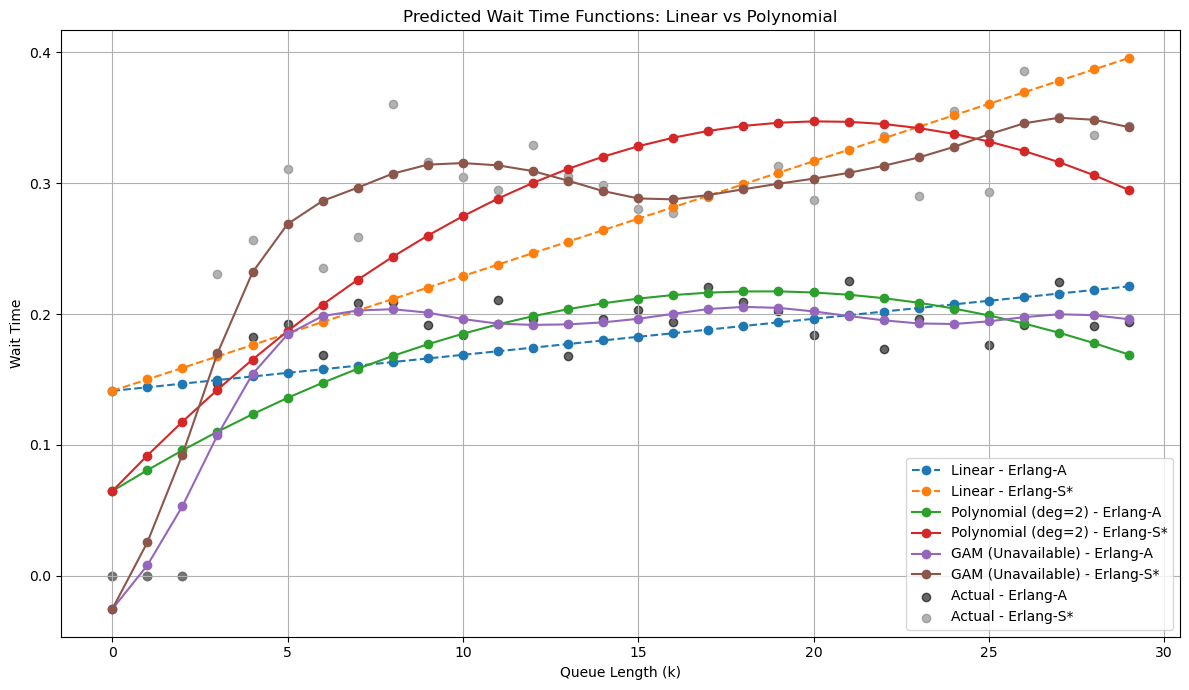

In [24]:
# Plot the predicted wait time functions from all three models

plt.figure(figsize=(12, 7))
for model, color, pred_col in zip(
    ['Linear', 'Polynomial (deg=2)', 'GAM (Unavailable)'],
    ['red', 'green', 'blue'],
    ['predicted_wait', 'pred_poly', 'pred_gam']  # pred_gam will be skipped
):
    if pred_col in df_combined.columns:
        for mtype in ['Erlang-A', 'Erlang-S*']:
            subset = df_combined[df_combined['model'] == mtype]
            plt.plot(subset['k'], subset[pred_col], label=f'{model} - {mtype}', linestyle='--' if model == 'Linear' else '-', marker='o')

# Plot actual data points
for mtype, color in zip(['Erlang-A', 'Erlang-S*'], ['black', 'gray']):
    subset = df_combined[df_combined['model'] == mtype]
    plt.scatter(subset['k'], subset['avg_wait'], label=f'Actual - {mtype}', color=color, alpha=0.6)

plt.title('Predicted Wait Time Functions: Linear vs Polynomial')
plt.xlabel('Queue Length (k)')
plt.ylabel('Wait Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Running Erlang-A Enhanced Simulation...

=== Erlang-A Simulation Results ===
Total Customers: 8972
Total Served: 8258
Total Abandoned: 714
Total Delayed: 2767
Average Wait Time: 0.0709
Average Customers on Arrival: 8.9993
Probability of Delay: 0.3084
Probability of Abandonment: 0.0796
Fraction of Abandonment (ε): 0.0796

Running Erlang-S* Enhanced Simulation...

=== Erlang-S* Simulation Results ===
Total Customers: 8986
Total Served: 7557
Total Abandoned: 1429
Total Delayed: 4275
Average Wait Time: 0.1547
Average Customers on Arrival: 11.0928
Probability of Delay: 0.4757
Probability of Abandonment: 0.1590
Fraction of Abandonment (ε): 0.1590

=== Staffing Optimization (Target ε = 0.05) ===
Erlang-A: Optimal servers = 12, Actual ε = 0.0254
Erlang-S*: Optimal servers = 15, Actual ε = 0.0411

=== Summary Comparison ===
       Model  Servers  Avg_Wait_Time  Prob_Delay  Prob_Abandonment  \
0   Erlang-A       10       0.070939    0.308404          0.079581   
1  Erlang-S*       10       0.154

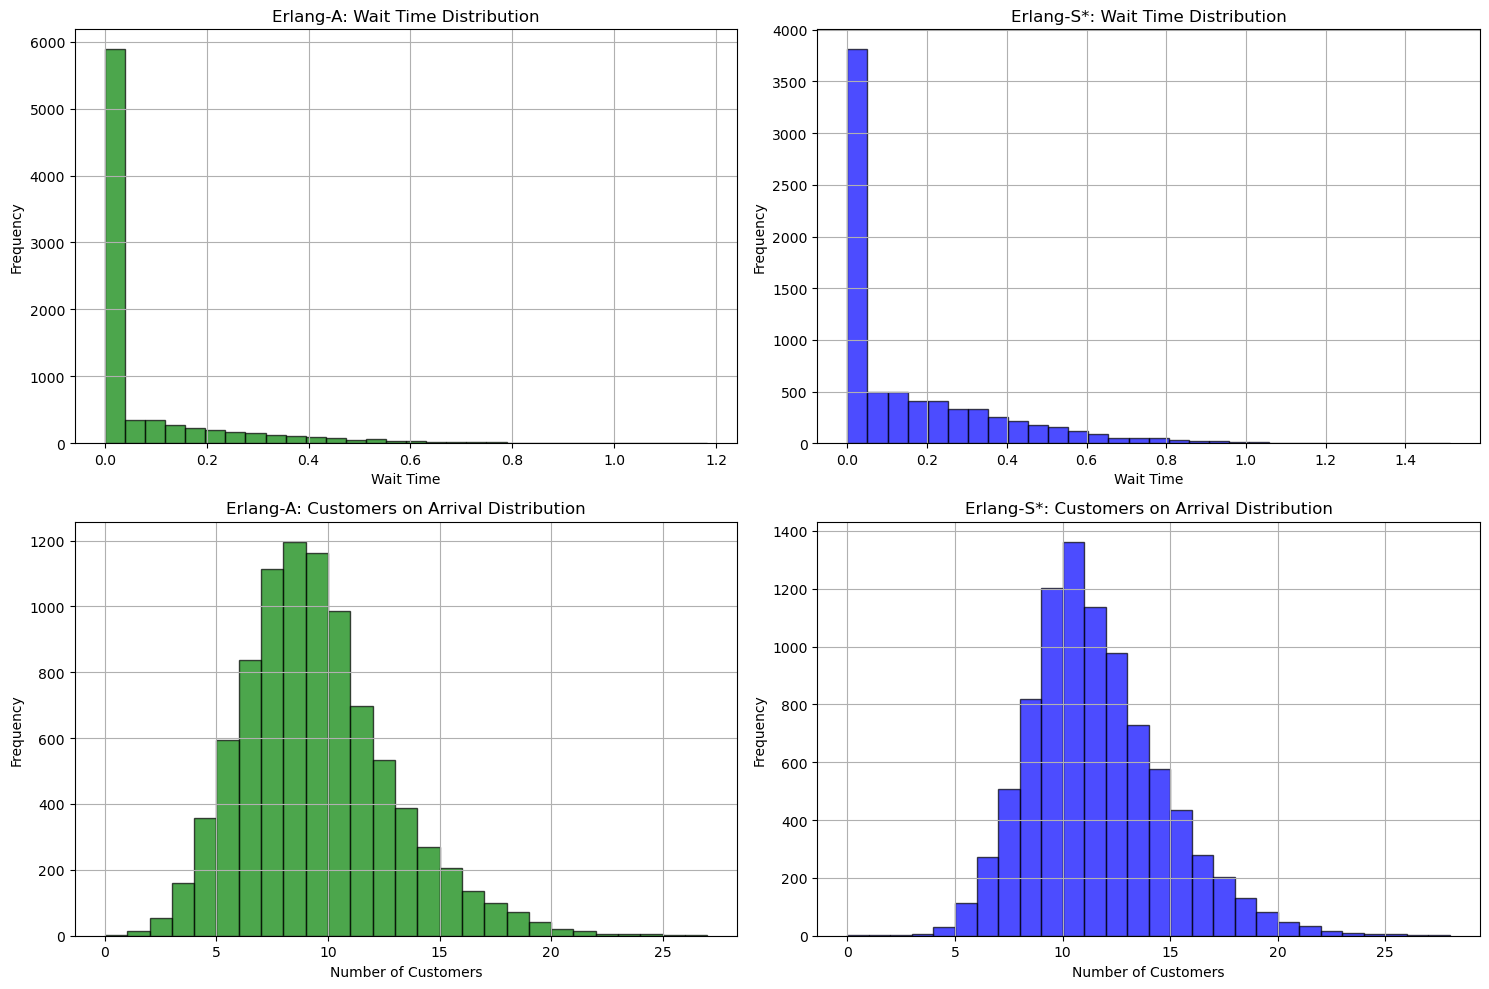

In [51]:
import numpy as np
import heapq
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass

@dataclass
class CustomerRecord:
    """Record for tracking individual customer metrics"""
    arrival_time: float
    departure_time: float = None
    wait_time: float = 0.0
    customers_on_arrival: int = 0
    delayed: bool = False
    abandoned: bool = False
    service_started: bool = False

def simulate_erlang_a_enhanced(
    lambda_rate: float,
    mu: float,
    c: int,
    theta: float,
    T: float,
    initial_queue: int = 0,
    seed: int = 42
) -> Dict:
    """Enhanced Erlang-A simulation with comprehensive metrics tracking"""
    np.random.seed(seed)
    time = 0.0
    next_arrival = np.random.exponential(1 / lambda_rate)
    
    servers = [{'busy': False, 'available_time': 0.0} for _ in range(c)]
    queue = []
    customer_records = []
    customer_id = 0
    
    # Add initial queue customers
    for i in range(initial_queue):
        patience_time = np.random.exponential(1 / theta)
        heapq.heappush(queue, (0.0, patience_time, customer_id))
        customer_records.append(CustomerRecord(
            arrival_time=0.0,
            customers_on_arrival=i,
            delayed=True
        ))
        customer_id += 1

    event_list = []
    heapq.heappush(event_list, (next_arrival, 'arrival', None))

    while event_list and time < T:
        time, event_type, server_id = heapq.heappop(event_list)

        if event_type == 'arrival':
            # Schedule next arrival
            next_arrival = time + np.random.exponential(1 / lambda_rate)
            if next_arrival < T:
                heapq.heappush(event_list, (next_arrival, 'arrival', None))

            # Count customers in system on arrival
            busy_servers = sum(1 for s in servers if s['busy'])
            customers_in_queue = len(queue)
            customers_on_arrival = busy_servers + customers_in_queue

            # Create customer record
            customer_record = CustomerRecord(
                arrival_time=time,
                customers_on_arrival=customers_on_arrival
            )

            available_servers = [i for i, s in enumerate(servers) if not s['busy']]
            if available_servers:
                # Immediate service
                sid = available_servers[0]
                service_time = np.random.exponential(1 / mu)
                servers[sid]['busy'] = True
                servers[sid]['available_time'] = time + service_time
                heapq.heappush(event_list, (time + service_time, 'departure', (sid, customer_id)))
                
                customer_record.wait_time = 0.0
                customer_record.delayed = False
                customer_record.service_started = True
                customer_record.departure_time = time + service_time
            else:
                # Join queue
                patience_time = np.random.exponential(1 / theta)
                heapq.heappush(queue, (time, patience_time, customer_id))
                customer_record.delayed = True

            customer_records.append(customer_record)
            customer_id += 1

        elif event_type == 'departure':
            sid, cust_id = server_id
            
            # Try to serve next customer from queue
            while queue:
                join_time, patience, queued_cust_id = heapq.heappop(queue)
                if time - join_time < patience:
                    # Customer still waiting, serve them
                    service_time = np.random.exponential(1 / mu)
                    servers[sid]['available_time'] = time + service_time
                    servers[sid]['busy'] = True
                    heapq.heappush(event_list, (time + service_time, 'departure', (sid, queued_cust_id)))
                    
                    # Update customer record
                    if queued_cust_id < len(customer_records):
                        customer_records[queued_cust_id].wait_time = time - join_time
                        customer_records[queued_cust_id].service_started = True
                        customer_records[queued_cust_id].departure_time = time + service_time
                    break
                else:
                    # Customer abandoned
                    if queued_cust_id < len(customer_records):
                        customer_records[queued_cust_id].abandoned = True
                        customer_records[queued_cust_id].departure_time = join_time + patience
            else:
                # No customers in queue, server becomes idle
                servers[sid]['busy'] = False

    # Calculate metrics
    served_customers = [c for c in customer_records if c.service_started and not c.abandoned]
    abandoned_customers = [c for c in customer_records if c.abandoned]
    delayed_customers = [c for c in customer_records if c.delayed and c.service_started]
    
    total_customers = len(customer_records)
    total_served = len(served_customers)
    total_abandoned = len(abandoned_customers)
    total_delayed = len(delayed_customers)
    
    metrics = {
        'total_customers': total_customers,
        'total_served': total_served,
        'total_abandoned': total_abandoned,
        'total_delayed': total_delayed,
        'avg_wait_time': np.mean([c.wait_time for c in served_customers]) if served_customers else 0.0,
        'avg_customers_on_arrival': np.mean([c.customers_on_arrival for c in customer_records]) if customer_records else 0.0,
        'prob_delay': total_delayed / total_customers if total_customers > 0 else 0.0,
        'prob_abandonment': total_abandoned / total_customers if total_customers > 0 else 0.0,
        'fraction_abandonment': total_abandoned / total_customers if total_customers > 0 else 0.0,
        'customer_records': customer_records,
        'wait_times': [c.wait_time for c in served_customers],
        'departure_times': [c.departure_time for c in customer_records if c.departure_time is not None]
    }
    
    return metrics

def simulate_erlang_s_star_enhanced(
    lambda_rate: float,
    mu: float,
    c: int,
    theta: float,
    p: float,
    gamma: float,
    T: float,
    initial_queue: int = 0,
    seed: int = 42
) -> Dict:
    """Enhanced Erlang-S* simulation with comprehensive metrics tracking"""
    np.random.seed(seed)
    time = 0.0
    next_arrival = np.random.exponential(1 / lambda_rate)
    
    servers = [{'busy': False, 'charging': False, 'available_time': 0.0} for _ in range(c)]
    queue = []
    customer_records = []
    customer_id = 0
    
    # Add initial queue customers
    for i in range(initial_queue):
        patience_time = np.random.exponential(1 / theta)
        heapq.heappush(queue, (0.0, patience_time, customer_id))
        customer_records.append(CustomerRecord(
            arrival_time=0.0,
            customers_on_arrival=i,
            delayed=True
        ))
        customer_id += 1

    event_list = []
    heapq.heappush(event_list, (next_arrival, 'arrival', None))

    while event_list and time < T:
        time, event_type, server_id = heapq.heappop(event_list)

        if event_type == 'arrival':
            next_arrival = time + np.random.exponential(1 / lambda_rate)
            if next_arrival < T:
                heapq.heappush(event_list, (next_arrival, 'arrival', None))

            # Count customers in system on arrival
            busy_servers = sum(1 for s in servers if s['busy'])
            customers_in_queue = len(queue)
            customers_on_arrival = busy_servers + customers_in_queue

            customer_record = CustomerRecord(
                arrival_time=time,
                customers_on_arrival=customers_on_arrival
            )

            available_servers = [i for i, s in enumerate(servers) if not s['busy'] and not s['charging']]
            if available_servers:
                sid = available_servers[0]
                service_time = np.random.exponential(1 / mu)
                servers[sid]['busy'] = True
                servers[sid]['available_time'] = time + service_time
                heapq.heappush(event_list, (time + service_time, 'departure', (sid, customer_id)))
                
                customer_record.wait_time = 0.0
                customer_record.delayed = False
                customer_record.service_started = True
                customer_record.departure_time = time + service_time
            else:
                patience_time = np.random.exponential(1 / theta)
                heapq.heappush(queue, (time, patience_time, customer_id))
                customer_record.delayed = True

            customer_records.append(customer_record)
            customer_id += 1

        elif event_type == 'departure':
            sid, cust_id = server_id
            
            while queue:
                join_time, patience, queued_cust_id = heapq.heappop(queue)
                if time - join_time < patience:
                    service_time = np.random.exponential(1 / mu)
                    servers[sid]['available_time'] = time + service_time
                    servers[sid]['busy'] = True
                    heapq.heappush(event_list, (time + service_time, 'departure', (sid, queued_cust_id)))
                    
                    if queued_cust_id < len(customer_records):
                        customer_records[queued_cust_id].wait_time = time - join_time
                        customer_records[queued_cust_id].service_started = True
                        customer_records[queued_cust_id].departure_time = time + service_time
                    break
                else:
                    if queued_cust_id < len(customer_records):
                        customer_records[queued_cust_id].abandoned = True
                        customer_records[queued_cust_id].departure_time = join_time + patience
            else:
                # Server becomes available for charging or idle
                if np.random.rand() < p:
                    charge_time = np.random.exponential(1 / gamma)
                    servers[sid]['charging'] = True
                    servers[sid]['available_time'] = time + charge_time
                    heapq.heappush(event_list, (time + charge_time, 'recharge', sid))
                else:
                    servers[sid]['busy'] = False

        elif event_type == 'recharge':
            sid = server_id
            servers[sid]['charging'] = False
            servers[sid]['busy'] = False

    # Calculate metrics (same as Erlang-A)
    served_customers = [c for c in customer_records if c.service_started and not c.abandoned]
    abandoned_customers = [c for c in customer_records if c.abandoned]
    delayed_customers = [c for c in customer_records if c.delayed and c.service_started]
    
    total_customers = len(customer_records)
    total_served = len(served_customers)
    total_abandoned = len(abandoned_customers)
    total_delayed = len(delayed_customers)
    
    metrics = {
        'total_customers': total_customers,
        'total_served': total_served,
        'total_abandoned': total_abandoned,
        'total_delayed': total_delayed,
        'avg_wait_time': np.mean([c.wait_time for c in served_customers]) if served_customers else 0.0,
        'avg_customers_on_arrival': np.mean([c.customers_on_arrival for c in customer_records]) if customer_records else 0.0,
        'prob_delay': total_delayed / total_customers if total_customers > 0 else 0.0,
        'prob_abandonment': total_abandoned / total_customers if total_customers > 0 else 0.0,
        'fraction_abandonment': total_abandoned / total_customers if total_customers > 0 else 0.0,
        'customer_records': customer_records,
        'wait_times': [c.wait_time for c in served_customers],
        'departure_times': [c.departure_time for c in customer_records if c.departure_time is not None]
    }
    
    return metrics

# add as input gamma for the simulation
def find_optimal_staffing(
    lambda_rate: float,
    mu: float,
    theta: float,
    target_abandonment_rate: float,
    T: float = 1000.0,
    max_servers: int = 500,
    model_type: str = 'erlang_a',
    **kwargs
) -> Tuple[int, float]:
    """
    Find optimal staffing level to achieve target abandonment rate
    
    Parameters:
    - target_abandonment_rate: desired fraction of abandonment (epsilon)
    - model_type: 'erlang_a' or 'erlang_s_star'
    """
    
    simulate_func = simulate_erlang_a_enhanced if model_type == 'erlang_a' else simulate_erlang_s_star_enhanced
    
    for c in range(1, max_servers + 1):
        if model_type == 'erlang_s_star':
            metrics = simulate_func(lambda_rate, mu, c, theta, T=T, **kwargs)
        else:
            metrics = simulate_func(lambda_rate, mu, c, theta, T=T)
        
        abandonment_rate = metrics['fraction_abandonment']
        
        if abandonment_rate <= target_abandonment_rate:
            return c, abandonment_rate
    
    return max_servers, metrics['fraction_abandonment']

def print_simulation_results(metrics: Dict, model_name: str):
    """Print comprehensive simulation results"""
    print(f"\n=== {model_name} Simulation Results ===")
    print(f"Total Customers: {metrics['total_customers']}")
    print(f"Total Served: {metrics['total_served']}")
    print(f"Total Abandoned: {metrics['total_abandoned']}")
    print(f"Total Delayed: {metrics['total_delayed']}")
    print(f"Average Wait Time: {metrics['avg_wait_time']:.4f}")
    print(f"Average Customers on Arrival: {metrics['avg_customers_on_arrival']:.4f}")
    print(f"Probability of Delay: {metrics['prob_delay']:.4f}")
    print(f"Probability of Abandonment: {metrics['prob_abandonment']:.4f}")
    print(f"Fraction of Abandonment (ε): {metrics['fraction_abandonment']:.4f}")

# Example usage
if __name__ == "__main__":
    # Parameters
    lambda_rate = 9
    mu = 1
    c = 10
    theta = 1.0
    p = 0.3
    gamma = 0.5
    T = 1000.0
    initial_queue = 5
    
    # Run Erlang-A simulation
    print("Running Erlang-A Enhanced Simulation...")
    results_a = simulate_erlang_a_enhanced(
        lambda_rate=lambda_rate,
        mu=mu,
        c=c,
        theta=theta,
        T=T,
        initial_queue=initial_queue
    )
    print_simulation_results(results_a, "Erlang-A")
    
    # Run Erlang-S* simulation
    print("\nRunning Erlang-S* Enhanced Simulation...")
    results_s_star = simulate_erlang_s_star_enhanced(
        lambda_rate=lambda_rate,
        mu=mu,
        c=c,
        theta=theta,
        p=p,
        gamma=gamma,
        T=T,
        initial_queue=initial_queue
    )
    print_simulation_results(results_s_star, "Erlang-S*")
    
    # Find optimal staffing for target abandonment rate
    target_epsilon = 0.05  # 5% abandonment rate
    
    print(f"\n=== Staffing Optimization (Target ε = {target_epsilon}) ===")
    
    # For Erlang-A
    optimal_c_a, actual_epsilon_a = find_optimal_staffing(
        lambda_rate=lambda_rate,
        mu=mu,
        theta=theta,
        target_abandonment_rate=target_epsilon,
        model_type='erlang_a'
    )
    print(f"Erlang-A: Optimal servers = {optimal_c_a}, Actual ε = {actual_epsilon_a:.4f}")
    
    # For Erlang-S*
    optimal_c_s, actual_epsilon_s = find_optimal_staffing(
        lambda_rate=lambda_rate,
        mu=mu,
        theta=theta,
        target_abandonment_rate=target_epsilon,
        model_type='erlang_s_star',
        p=p,
        gamma=gamma
    )
    print(f"Erlang-S*: Optimal servers = {optimal_c_s}, Actual ε = {actual_epsilon_s:.4f}")
    
    # Create summary DataFrame
    summary_data = {
        'Model': ['Erlang-A', 'Erlang-S*'],
        'Servers': [c, c],
        'Avg_Wait_Time': [results_a['avg_wait_time'], results_s_star['avg_wait_time']],
        'Prob_Delay': [results_a['prob_delay'], results_s_star['prob_delay']],
        'Prob_Abandonment': [results_a['prob_abandonment'], results_s_star['prob_abandonment']],
        'Fraction_Abandonment': [results_a['fraction_abandonment'], results_s_star['fraction_abandonment']],
        'Avg_Customers_on_Arrival': [results_a['avg_customers_on_arrival'], results_s_star['avg_customers_on_arrival']]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(f"\n=== Summary Comparison ===")
    print(summary_df)
    
    # Plot wait time distributions
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(results_a['wait_times'], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.title('Erlang-A: Wait Time Distribution')
    plt.xlabel('Wait Time')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.hist(results_s_star['wait_times'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Erlang-S*: Wait Time Distribution')
    plt.xlabel('Wait Time')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    customers_on_arrival_a = [c.customers_on_arrival for c in results_a['customer_records']]
    plt.hist(customers_on_arrival_a, bins=range(max(customers_on_arrival_a)+2), alpha=0.7, color='green', edgecolor='black')
    plt.title('Erlang-A: Customers on Arrival Distribution')
    plt.xlabel('Number of Customers')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    customers_on_arrival_s = [c.customers_on_arrival for c in results_s_star['customer_records']]
    plt.hist(customers_on_arrival_s, bins=range(max(customers_on_arrival_s)+2), alpha=0.7, color='blue', edgecolor='black')
    plt.title('Erlang-S*: Customers on Arrival Distribution')
    plt.xlabel('Number of Customers')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Running Erlang-A Enhanced Simulation...

=== Erlang-A Simulation Results ===
Total Customers: 15072
Total Served: 11702
Total Abandoned: 3370
Total Delayed: 8898
Average Wait Time: 0.2231
Average Customers on Arrival: 15.7723
Probability of Delay: 0.5904
Probability of Abandonment: 0.2236
Fraction of Abandonment (ε): 0.2236

Running Erlang-S* Enhanced Simulation...

=== Erlang-S* Simulation Results ===
Total Customers: 15101
Total Served: 10259
Total Abandoned: 4839
Total Delayed: 9121
Average Wait Time: 0.3437
Average Customers on Arrival: 18.3291
Probability of Delay: 0.6040
Probability of Abandonment: 0.3204
Fraction of Abandonment (ε): 0.3204

=== Staffing Optimization (Target ε = 0.05) ===
Erlang-A: Optimal servers = 17, Actual ε = 0.0454
Erlang-S*: Optimal servers = 31, Actual ε = 0.0477

=== Summary Comparison ===
       Model  Servers  Avg_Wait_Time  Prob_Delay  Prob_Abandonment  \
0   Erlang-A       12       0.223065    0.590366          0.223593   
1  Erlang-S*       12      

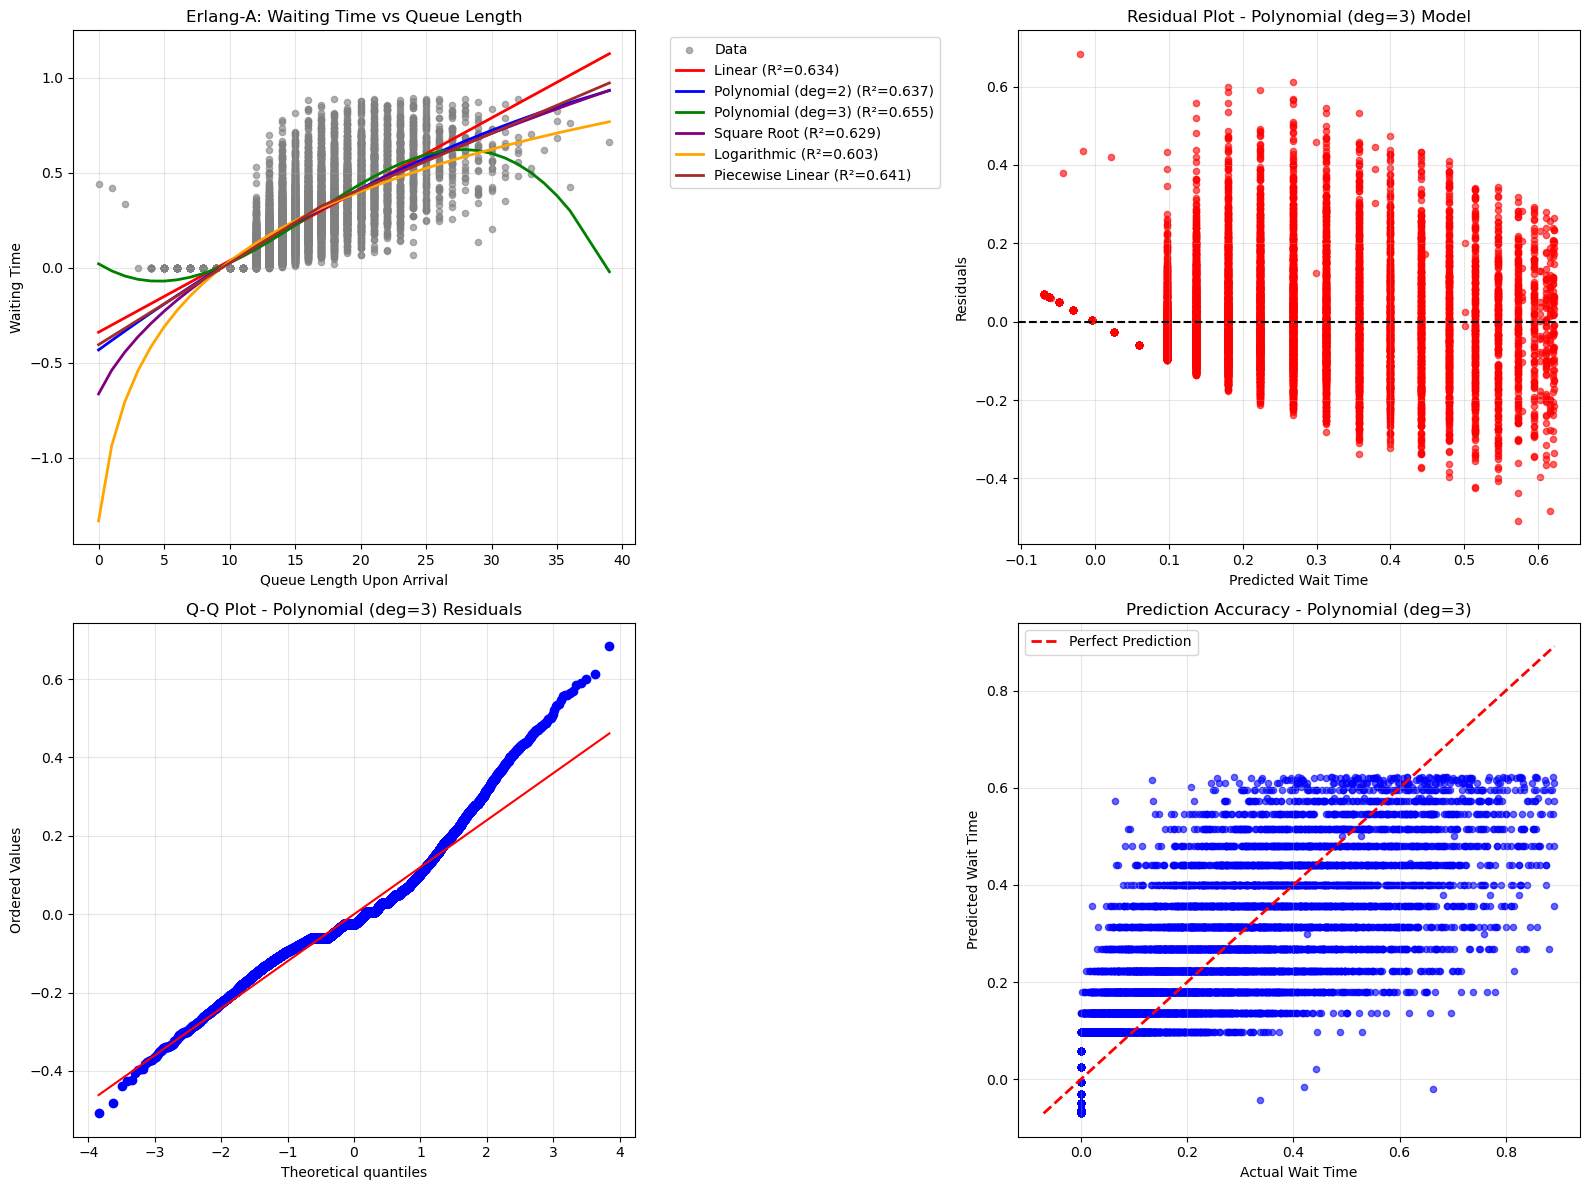


=== Erlang-S*: Waiting Time Regression Analysis ===
Total served customers: 10259
Customers used for fitting (after outlier removal): 10156
Queue length range: 0 - 43
Wait time range: 0.0000 - 1.0929

Model Comparison:
Model                R²         RMSE       Equation
Linear               0.5124     0.1793     Wait Time = -0.3130 + 0.0377 × Queue Length
Polynomial (deg=2)   0.5389     0.1744     Wait Time = a + b×Queue + c×Queue²
Polynomial (deg=3)   0.5392     0.1743     Wait Time = a + b×Queue + c×Queue² + d×Queue³
Square Root          0.5265     0.1767     Wait Time = -1.0764 + 0.3340 × √(Queue+1)
Logarithmic          0.5255     0.1769     Wait Time = -1.6928 + 0.7077 × ln(Queue+1)
Piecewise Linear     0.5410     0.1740     Wait Time = -0.5174 + 0.0518×min(Queue,19.0) + 0.0...

Best Model: Piecewise Linear (R² = 0.5410)

Linear Model Statistics:
Correlation coefficient: 0.7158
P-value: 0.000000
Slope: 0.0377
Linear relationship is statistically significant (p < 0.05)


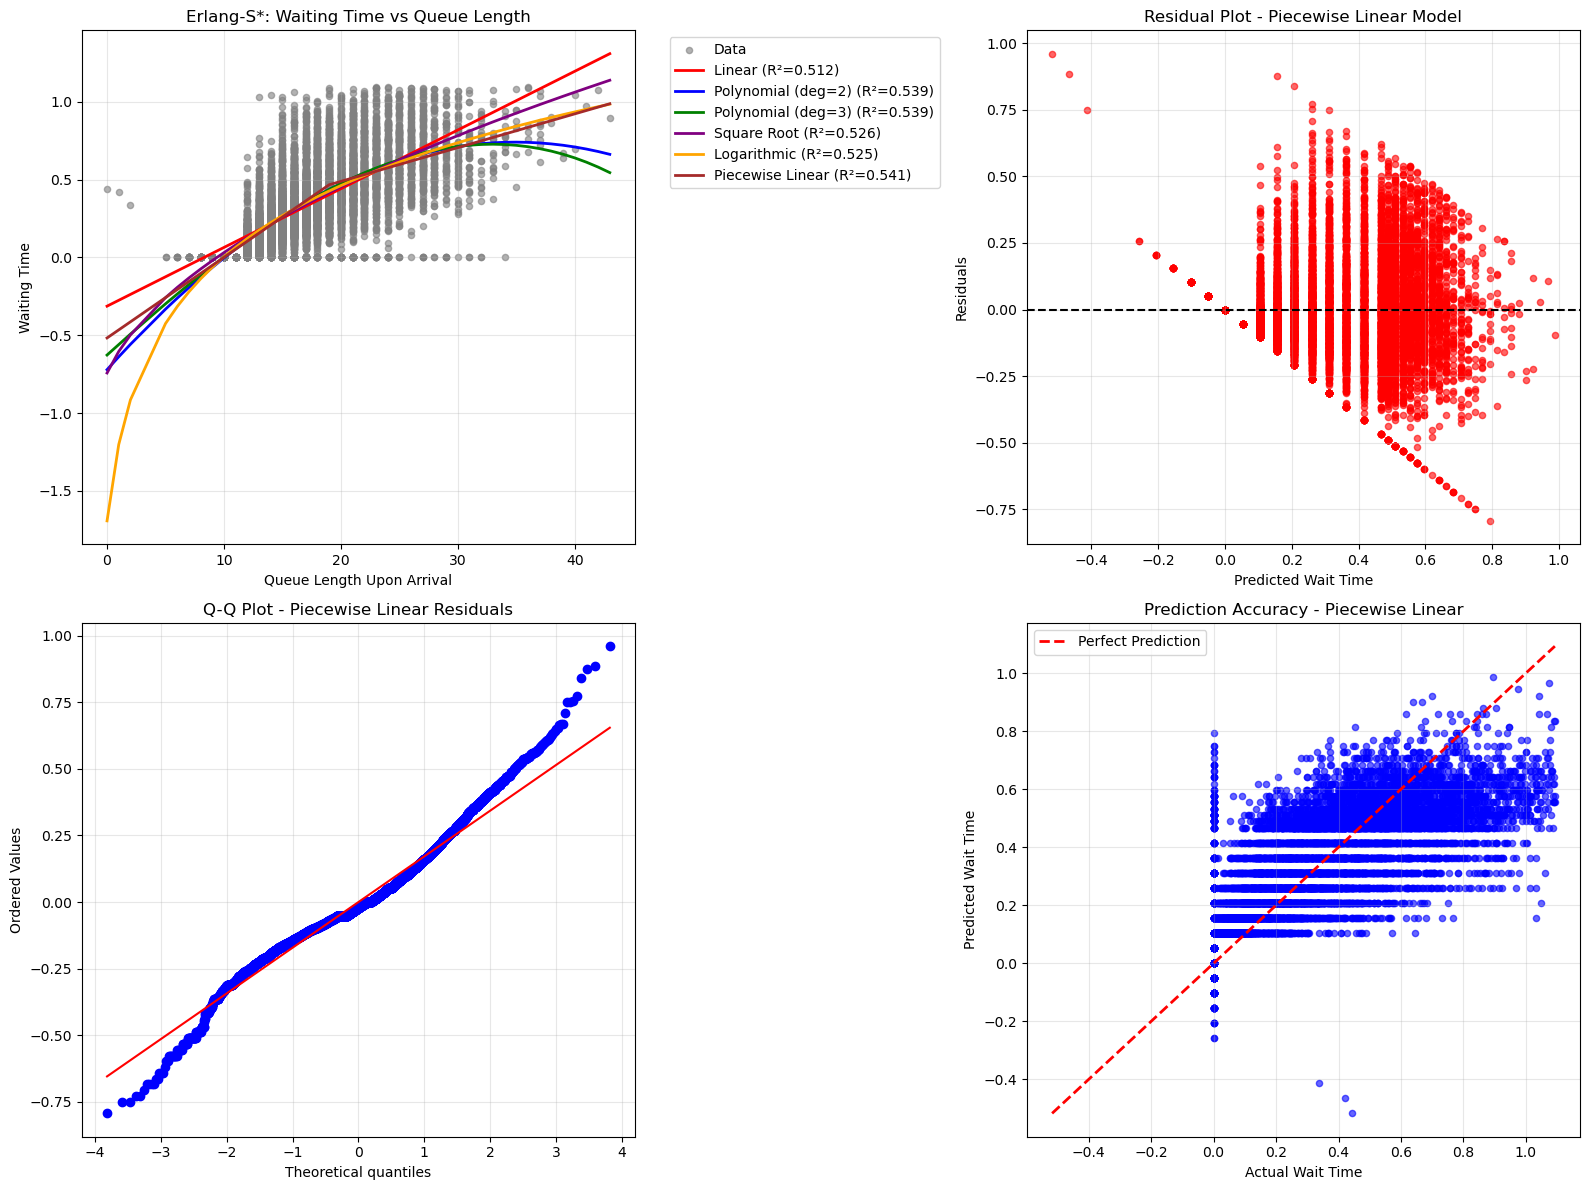


=== Erlang-A: Wait Time Predictions ===
Queue Length 0: Predicted Wait Time = 0.0211
Queue Length 1: Predicted Wait Time = -0.0160
Queue Length 5: Predicted Wait Time = -0.0698
Queue Length 10: Predicted Wait Time = 0.0254
Queue Length 15: Predicted Wait Time = 0.2233

=== Erlang-S*: Wait Time Predictions ===


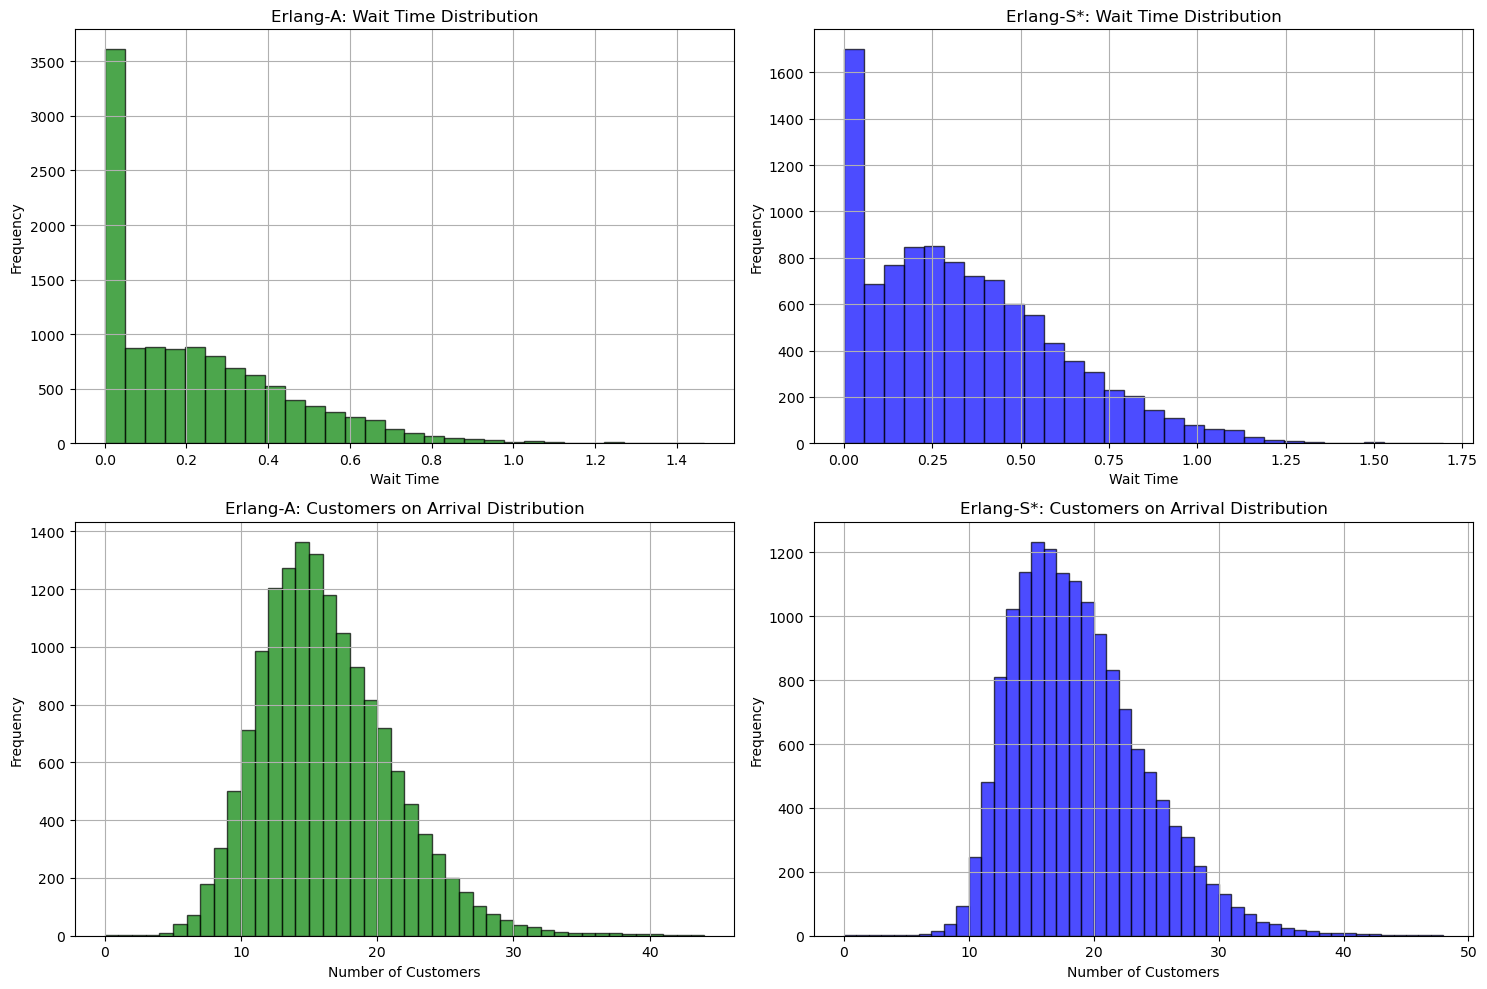

In [53]:
def print_simulation_results(metrics: Dict, model_name: str):
    """Print comprehensive simulation results"""
    print(f"\n=== {model_name} Simulation Results ===")
    print(f"Total Customers: {metrics['total_customers']}")
    print(f"Total Served: {metrics['total_served']}")
    print(f"Total Abandoned: {metrics['total_abandoned']}")
    print(f"Total Delayed: {metrics['total_delayed']}")
    print(f"Average Wait Time: {metrics['avg_wait_time']:.4f}")
    print(f"Average Customers on Arrival: {metrics['avg_customers_on_arrival']:.4f}")
    print(f"Probability of Delay: {metrics['prob_delay']:.4f}")
    print(f"Probability of Abandonment: {metrics['prob_abandonment']:.4f}")
    print(f"Fraction of Abandonment (ε): {metrics['fraction_abandonment']:.4f}")

def predict_wait_time(queue_length: int, model_results: Dict, model_name: str = 'Linear') -> float:
    """
    Predict waiting time for a given queue length using the specified model
    """
    if model_results is None or model_name not in model_results['models']:
        return None
    
    model_info = model_results['models'][model_name]
    model = model_info['model']
    
    X_pred = np.array([[queue_length]])
    
    if model_name == 'Linear':
        return model.predict(X_pred)[0]
    elif 'Polynomial' in model_name:
        return model.predict(X_pred)[0]
    elif model_name == 'Exponential':
        log_pred = model.predict(X_pred)[0]
        return np.exp(log_pred)
    elif model_name == 'Power Law':
        log_x = np.log(queue_length + 1)
        log_pred = model.predict(np.array([[log_x]]))[0]
        return np.exp(model_info['model'].intercept_) * ((queue_length + 1) ** model_info['model'].coef_[0])
    
    return None

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def fit_waiting_time_models(customer_records, model_name: str = "Model"):
    """
    Fit various regression models to predict waiting time based on queue length upon arrival
    """
    # Prepare data - only include customers who were served (not abandoned)
    served_customers = [c for c in customer_records if c.service_started and not c.abandoned]
    
    if len(served_customers) < 10:
        print(f"Not enough served customers ({len(served_customers)}) for regression analysis")
        return None
    
    # Extract features and target
    X = np.array([c.customers_on_arrival for c in served_customers]).reshape(-1, 1)
    y = np.array([c.wait_time for c in served_customers])
    
    # Remove any potential outliers (wait times > 99th percentile)
    percentile_99 = np.percentile(y, 99)
    mask = y <= percentile_99
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    print(f"\n=== {model_name}: Waiting Time Regression Analysis ===")
    print(f"Total served customers: {len(served_customers)}")
    print(f"Customers used for fitting (after outlier removal): {len(y_filtered)}")
    print(f"Queue length range: {X_filtered.min():.0f} - {X_filtered.max():.0f}")
    print(f"Wait time range: {y_filtered.min():.4f} - {y_filtered.max():.4f}")
    
    models = {}
    
    # 1. Linear Regression
    linear_reg = LinearRegression()
    linear_reg.fit(X_filtered, y_filtered)
    y_pred_linear = linear_reg.predict(X_filtered)
    
    models['Linear'] = {
        'model': linear_reg,
        'predictions': y_pred_linear,
        'r2': r2_score(y_filtered, y_pred_linear),
        'rmse': np.sqrt(mean_squared_error(y_filtered, y_pred_linear)),
        'equation': f"Wait Time = {linear_reg.intercept_:.4f} + {linear_reg.coef_[0]:.4f} × Queue Length"
    }
    
    # 2. Polynomial Regression (degree 2)
    poly_reg_2 = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
    poly_reg_2.fit(X_filtered, y_filtered)
    y_pred_poly2 = poly_reg_2.predict(X_filtered)
    
    models['Polynomial (deg=2)'] = {
        'model': poly_reg_2,
        'predictions': y_pred_poly2,
        'r2': r2_score(y_filtered, y_pred_poly2),
        'rmse': np.sqrt(mean_squared_error(y_filtered, y_pred_poly2)),
        'equation': "Wait Time = a + b×Queue + c×Queue²"
    }
    
    # 3. Polynomial Regression (degree 3)
    if len(np.unique(X_filtered)) > 3:  # Need enough unique values for degree 3
        poly_reg_3 = Pipeline([
            ('poly', PolynomialFeatures(degree=3)),
            ('linear', LinearRegression())
        ])
        poly_reg_3.fit(X_filtered, y_filtered)
        y_pred_poly3 = poly_reg_3.predict(X_filtered)
        
        models['Polynomial (deg=3)'] = {
            'model': poly_reg_3,
            'predictions': y_pred_poly3,
            'r2': r2_score(y_filtered, y_pred_poly3),
            'rmse': np.sqrt(mean_squared_error(y_filtered, y_pred_poly3)),
            'equation': "Wait Time = a + b×Queue + c×Queue² + d×Queue³"
        }
    
    # 4. Exponential Model (using log transformation)
    # Only if we have positive queue lengths and wait times
    if np.all(X_filtered > 0) and np.all(y_filtered > 0):
        try:
            # Fit: log(y) = a + b*x, so y = exp(a + b*x)
            log_y = np.log(y_filtered + 1e-6)  # Add small constant to avoid log(0)
            exp_reg = LinearRegression()
            exp_reg.fit(X_filtered, log_y)
            y_pred_exp = np.exp(exp_reg.predict(X_filtered))
            
            # Check if predictions are reasonable
            if not np.any(np.isinf(y_pred_exp)) and not np.any(np.isnan(y_pred_exp)):
                models['Exponential'] = {
                    'model': exp_reg,
                    'predictions': y_pred_exp,
                    'r2': r2_score(y_filtered, y_pred_exp),
                    'rmse': np.sqrt(mean_squared_error(y_filtered, y_pred_exp)),
                    'equation': f"Wait Time = exp({exp_reg.intercept_:.4f} + {exp_reg.coef_[0]:.4f} × Queue Length)"
                }
        except:
            pass
    
    # 5. Power Law Model (if applicable)
    if np.all(X_filtered > 0) and np.all(y_filtered > 0):
        try:
            # Fit: log(y) = a + b*log(x), so y = x^b * exp(a)
            log_x = np.log(X_filtered + 1)  # Add 1 to handle queue length = 0
            log_y = np.log(y_filtered + 1e-6)
            power_reg = LinearRegression()
            power_reg.fit(log_x, log_y)
            y_pred_power = np.exp(power_reg.intercept_) * ((X_filtered + 1) ** power_reg.coef_[0])
            
            # Check if predictions are reasonable
            if not np.any(np.isinf(y_pred_power)) and not np.any(np.isnan(y_pred_power)):
                models['Power Law'] = {
                    'model': power_reg,
                    'predictions': y_pred_power,
                    'r2': r2_score(y_filtered, y_pred_power),
                    'rmse': np.sqrt(mean_squared_error(y_filtered, y_pred_power)),
                    'equation': f"Wait Time = {np.exp(power_reg.intercept_):.4f} × (Queue+1)^{power_reg.coef_[0]:.4f}"
                }
        except:
            pass
    
    # 6. NEW: Square Root Model
    # This model assumes wait time grows as the square root of queue length
    # Often useful for queueing systems where congestion effects are sublinear
    try:
        X_sqrt = np.sqrt(X_filtered + 1)  # Add 1 to handle queue length = 0
        sqrt_reg = LinearRegression()
        sqrt_reg.fit(X_sqrt, y_filtered)
        y_pred_sqrt = sqrt_reg.predict(X_sqrt)
        
        # Check if predictions are reasonable
        if not np.any(np.isnan(y_pred_sqrt)) and sqrt_reg.score(X_sqrt, y_filtered) > 0:
            models['Square Root'] = {
                'model': sqrt_reg,
                'predictions': y_pred_sqrt,
                'r2': r2_score(y_filtered, y_pred_sqrt),
                'rmse': np.sqrt(mean_squared_error(y_filtered, y_pred_sqrt)),
                'equation': f"Wait Time = {sqrt_reg.intercept_:.4f} + {sqrt_reg.coef_[0]:.4f} × √(Queue+1)"
            }
    except:
        pass
    
    # 7. NEW: Logarithmic Model
    # This model assumes diminishing returns - wait time increases logarithmically
    # Good for systems where additional queue length has decreasing marginal impact
    try:
        X_log = np.log(X_filtered + 1)  # Add 1 to handle queue length = 0
        log_reg = LinearRegression()
        log_reg.fit(X_log.reshape(-1, 1), y_filtered)
        y_pred_log = log_reg.predict(X_log.reshape(-1, 1))
        
        # Check if predictions are reasonable
        if not np.any(np.isnan(y_pred_log)) and log_reg.score(X_log.reshape(-1, 1), y_filtered) > 0:
            models['Logarithmic'] = {
                'model': log_reg,
                'predictions': y_pred_log,
                'r2': r2_score(y_filtered, y_pred_log),
                'rmse': np.sqrt(mean_squared_error(y_filtered, y_pred_log)),
                'equation': f"Wait Time = {log_reg.intercept_:.4f} + {log_reg.coef_[0]:.4f} × ln(Queue+1)"
            }
    except:
        pass
    
    # 8. NEW: Piecewise Linear Model (Two-segment)
    # This model fits different linear relationships before and after a breakpoint
    # Useful if queueing behavior changes at certain congestion levels
    try:
        if len(np.unique(X_filtered)) > 10:  # Need enough data points
            # Find optimal breakpoint by trying different percentiles
            best_r2 = -1
            best_breakpoint = None
            best_piecewise_model = None
            
            for percentile in [25, 33, 50, 67, 75]:
                breakpoint = np.percentile(X_filtered, percentile)
                
                # Create piecewise features
                X_piece1 = np.minimum(X_filtered, breakpoint)
                X_piece2 = np.maximum(X_filtered - breakpoint, 0)
                X_piecewise = np.column_stack([X_piece1, X_piece2])
                
                piecewise_reg = LinearRegression()
                piecewise_reg.fit(X_piecewise, y_filtered)
                y_pred_piecewise = piecewise_reg.predict(X_piecewise)
                
                r2_piecewise = r2_score(y_filtered, y_pred_piecewise)
                
                if r2_piecewise > best_r2:
                    best_r2 = r2_piecewise
                    best_breakpoint = breakpoint
                    best_piecewise_model = {
                        'model': piecewise_reg,
                        'breakpoint': breakpoint,
                        'predictions': y_pred_piecewise,
                        'X_piecewise': X_piecewise
                    }
            
            if best_piecewise_model is not None and best_r2 > 0:
                coef1, coef2 = best_piecewise_model['model'].coef_
                intercept = best_piecewise_model['model'].intercept_
                
                models['Piecewise Linear'] = {
                    'model': best_piecewise_model['model'],
                    'predictions': best_piecewise_model['predictions'],
                    'r2': best_r2,
                    'rmse': np.sqrt(mean_squared_error(y_filtered, best_piecewise_model['predictions'])),
                    'equation': f"Wait Time = {intercept:.4f} + {coef1:.4f}×min(Queue,{best_breakpoint:.1f}) + {coef2:.4f}×max(0,Queue-{best_breakpoint:.1f})",
                    'breakpoint': best_breakpoint,
                    'X_piecewise': best_piecewise_model['X_piecewise']
                }
    except:
        pass
    
    # Print model comparison
    print("\nModel Comparison:")
    print("=" * 80)
    print(f"{'Model':<20} {'R²':<10} {'RMSE':<10} {'Equation'}")
    print("=" * 80)
    
    for name, model_info in models.items():
        equation = model_info['equation'][:50] + "..." if len(model_info['equation']) > 50 else model_info['equation']
        print(f"{name:<20} {model_info['r2']:<10.4f} {model_info['rmse']:<10.4f} {equation}")
    
    # Find best model
    best_model_name = max(models.keys(), key=lambda k: models[k]['r2'])
    best_model = models[best_model_name]
    print(f"\nBest Model: {best_model_name} (R² = {best_model['r2']:.4f})")
    
    # Statistical significance test for linear model
    if len(y_filtered) > 2:
        slope = models['Linear']['model'].coef_[0]
        # Calculate correlation coefficient and p-value
        correlation_coef, p_value = stats.pearsonr(X_filtered.flatten(), y_filtered)
        print(f"\nLinear Model Statistics:")
        print(f"Correlation coefficient: {correlation_coef:.4f}")
        print(f"P-value: {p_value:.6f}")
        print(f"Slope: {slope:.4f}")
        if p_value < 0.05:
            print("Linear relationship is statistically significant (p < 0.05)")
        else:
            print("Linear relationship is not statistically significant (p >= 0.05)")
    
    # Create visualization
    plt.figure(figsize=(16, 12))
    
    # Scatter plot with regression lines
    plt.subplot(2, 2 , 1)
    plt.scatter(X_filtered, y_filtered, alpha=0.6, color='gray', s=20, label='Data')
    
    # Sort for smooth lines
    sort_idx = np.argsort(X_filtered.flatten())
    X_sorted = X_filtered[sort_idx]
    
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'cyan']
    for i, (name, model_info) in enumerate(models.items()):
        y_sorted = model_info['predictions'][sort_idx]
        plt.plot(X_sorted, y_sorted, color=colors[i % len(colors)], 
                linewidth=2, label=f"{name} (R²={model_info['r2']:.3f})")
    
    plt.xlabel('Queue Length Upon Arrival')
    plt.ylabel('Waiting Time')
    plt.title(f'{model_name}: Waiting Time vs Queue Length')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Residual plots for best model
    plt.subplot(2, 2, 2)
    residuals = y_filtered - best_model['predictions']
    plt.scatter(best_model['predictions'], residuals, alpha=0.6, color='red', s=20)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted Wait Time')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {best_model_name} Model')
    plt.grid(True, alpha=0.3)
    
    # Q-Q plot for residuals (normality check)
    plt.subplot(2, 2, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot - {best_model_name} Residuals')
    plt.grid(True, alpha=0.3)
    
    # Model comparison bar chart (R²)
    # plt.subplot(2, 3, 4)
    # model_names = list(models.keys())
    # r2_scores = [models[name]['r2'] for name in model_names]
    # bars = plt.bar(model_names, r2_scores, color=colors[:len(model_names)])
    # plt.ylabel('R² Score')
    # plt.title('Model Comparison (R² Score)')
    # plt.xticks(rotation=45, ha='right')
    # plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    # for bar, score in zip(bars, r2_scores):
    #     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
    #             f'{score:.3f}', ha='center', va='bottom', fontsize=8)
    
    # RMSE comparison
    # plt.subplot(2, 3, 5)
    # rmse_scores = [models[name]['rmse'] for name in model_names]
    # bars = plt.bar(model_names, rmse_scores, color=colors[:len(model_names)])
    # plt.ylabel('RMSE')
    # plt.title('Model Comparison (RMSE)')
    # plt.xticks(rotation=45, ha='right')
    # plt.grid(True, alpha=0.3, axis='y')
    
    # # Add value labels on bars
    # for bar, score in zip(bars, rmse_scores):
    #     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
    #             f'{score:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Prediction accuracy scatter plot
    plt.subplot(2, 2, 4)
    plt.scatter(y_filtered, best_model['predictions'], alpha=0.6, color='blue', s=20)
    min_val = min(y_filtered.min(), best_model['predictions'].min())
    max_val = max(y_filtered.max(), best_model['predictions'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Actual Wait Time')
    plt.ylabel('Predicted Wait Time')
    plt.title(f'Prediction Accuracy - {best_model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'data': {'X': X_filtered, 'y': y_filtered},
        'models': models,
        'best_model': best_model_name,
        'statistics': {
            'correlation': correlation_coef if len(y_filtered) > 2 else None,
            'p_value': p_value if len(y_filtered) > 2 else None
        }
    }

# Example usage
if __name__ == "__main__":
    # Parameters
    lambda_rate = 15
    mu = 1
    c = 12
    theta = 1.0
    p = 0.3
    gamma = 0.2
    T = 1000.0
    initial_queue = 5
    
    # Run Erlang-A simulation
    print("Running Erlang-A Enhanced Simulation...")
    results_a = simulate_erlang_a_enhanced(
        lambda_rate=lambda_rate,
        mu=mu,
        c=c,
        theta=theta,
        T=T,
        initial_queue=initial_queue
    )
    print_simulation_results(results_a, "Erlang-A")
    
    # Run Erlang-S* simulation
    print("\nRunning Erlang-S* Enhanced Simulation...")
    results_s_star = simulate_erlang_s_star_enhanced(
        lambda_rate=lambda_rate,
        mu=mu,
        c=c,
        theta=theta,
        p=p,
        gamma=gamma,
        T=T,
        initial_queue=initial_queue
    )
    print_simulation_results(results_s_star, "Erlang-S*")
    
    # Find optimal staffing for target abandonment rate
    target_epsilon = 0.05  # 5% abandonment rate
    
    print(f"\n=== Staffing Optimization (Target ε = {target_epsilon}) ===")
    
    # For Erlang-A
    optimal_c_a, actual_epsilon_a = find_optimal_staffing(
        lambda_rate=lambda_rate,
        mu=mu,
        theta=theta,
        target_abandonment_rate=target_epsilon,
        model_type='erlang_a'
    )
    print(f"Erlang-A: Optimal servers = {optimal_c_a}, Actual ε = {actual_epsilon_a:.4f}")
    
    # For Erlang-S*
    optimal_c_s, actual_epsilon_s = find_optimal_staffing(
        lambda_rate=lambda_rate,
        mu=mu,
        theta=theta,
        target_abandonment_rate=target_epsilon,
        model_type='erlang_s_star',
        p=p,
        gamma=gamma
    )
    print(f"Erlang-S*: Optimal servers = {optimal_c_s}, Actual ε = {actual_epsilon_s:.4f}")
    
    # Create summary DataFrame
    summary_data = {
        'Model': ['Erlang-A', 'Erlang-S*'],
        'Servers': [c, c],
        'Avg_Wait_Time': [results_a['avg_wait_time'], results_s_star['avg_wait_time']],
        'Prob_Delay': [results_a['prob_delay'], results_s_star['prob_delay']],
        'Prob_Abandonment': [results_a['prob_abandonment'], results_s_star['prob_abandonment']],
        'Fraction_Abandonment': [results_a['fraction_abandonment'], results_s_star['fraction_abandonment']],
        'Avg_Customers_on_Arrival': [results_a['avg_customers_on_arrival'], results_s_star['avg_customers_on_arrival']]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(f"\n=== Summary Comparison ===")
    print(summary_df)
    
    # Run regression analysis
    print("\n" + "="*80)
    print("REGRESSION ANALYSIS: Waiting Time vs Queue Length Upon Arrival")
    print("="*80)
    
    # Fit models for Erlang-A
    regression_results_a = fit_waiting_time_models(results_a['customer_records'], "Erlang-A")
    
    # Fit models for Erlang-S*
    regression_results_s = fit_waiting_time_models(results_s_star['customer_records'], "Erlang-S*")
    
    # Example predictions
    if regression_results_a is not None:
        print(f"\n=== Erlang-A: Wait Time Predictions ===")
        for queue_len in [0, 1, 5, 10, 15]:
            best_model_name = regression_results_a['best_model']
            predicted_wait = predict_wait_time(queue_len, regression_results_a, best_model_name)
            if predicted_wait is not None:
                print(f"Queue Length {queue_len}: Predicted Wait Time = {predicted_wait:.4f}")
    
    if regression_results_s is not None:
        print(f"\n=== Erlang-S*: Wait Time Predictions ===")
        for queue_len in [0, 1, 5, 10, 15]:
            best_model_name = regression_results_s['best_model']
            predicted_wait = predict_wait_time(queue_len, regression_results_s, best_model_name)
            if predicted_wait is not None:
                print(f"Queue Length {queue_len}: Predicted Wait Time = {predicted_wait:.4f}")
    
    # Original plotting code
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(results_a['wait_times'], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.title('Erlang-A: Wait Time Distribution')
    plt.xlabel('Wait Time')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.hist(results_s_star['wait_times'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Erlang-S*: Wait Time Distribution')
    plt.xlabel('Wait Time')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    customers_on_arrival_a = [c.customers_on_arrival for c in results_a['customer_records']]
    plt.hist(customers_on_arrival_a, bins=range(max(customers_on_arrival_a)+2), alpha=0.7, color='green', edgecolor='black')
    plt.title('Erlang-A: Customers on Arrival Distribution')
    plt.xlabel('Number of Customers')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    customers_on_arrival_s = [c.customers_on_arrival for c in results_s_star['customer_records']]
    plt.hist(customers_on_arrival_s, bins=range(max(customers_on_arrival_s)+2), alpha=0.7, color='blue', edgecolor='black')
    plt.title('Erlang-S*: Customers on Arrival Distribution')
    plt.xlabel('Number of Customers')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Epsilon: 0.01, Erlang-A Optimal Servers: 109, Actual Epsilon: 0.0099
Epsilon: 0.01, Erlang-S* Optimal Servers: 170, Actual Epsilon: 0.0095
Epsilon: 0.05, Erlang-A Optimal Servers: 100, Actual Epsilon: 0.0431
Epsilon: 0.05, Erlang-S* Optimal Servers: 120, Actual Epsilon: 0.0463
Epsilon: 0.08, Erlang-A Optimal Servers: 93, Actual Epsilon: 0.0823
Epsilon: 0.08, Erlang-S* Optimal Servers: 102, Actual Epsilon: 0.0823
Epsilon: 0.12, Erlang-A Optimal Servers: 90, Actual Epsilon: 0.1085
Epsilon: 0.12, Erlang-S* Optimal Servers: 93, Actual Epsilon: 0.1167
Epsilon: 0.16, Erlang-A Optimal Servers: 85, Actual Epsilon: 0.1505
Epsilon: 0.16, Erlang-S* Optimal Servers: 88, Actual Epsilon: 0.1421
Epsilon: 0.19, Erlang-A Optimal Servers: 81, Actual Epsilon: 0.1875
Epsilon: 0.19, Erlang-S* Optimal Servers: 82, Actual Epsilon: 0.1901
Epsilon: 0.23, Erlang-A Optimal Servers: 77, Actual Epsilon: 0.2275
Epsilon: 0.23, Erlang-S* Optimal Servers: 78, Actual Epsilon: 0.2258
Epsilon: 0.26, Erlang-A Optimal Serv

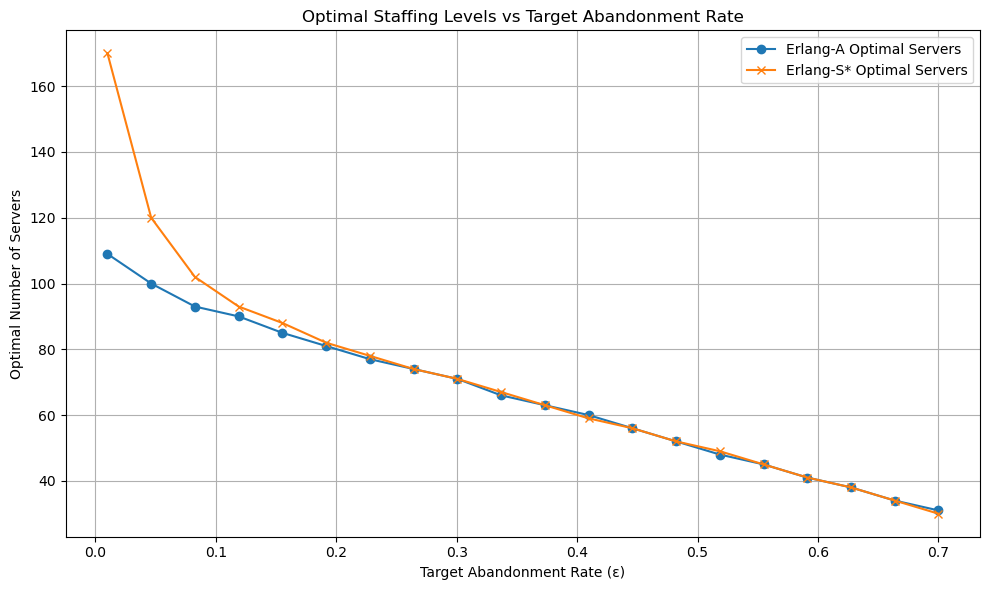

In [52]:
epsilon_vec = np.linspace(0.01, 0.7, 20)
lambda_rate_1 = 100
mu_1 = 1
theta_1 = 1
Time_horizon_1 = 1000.0
p_1 = 0.5
gamma_1 = 0.5
result_experiment = {}

for epsilon in epsilon_vec:

    optimal_c_a1, optimal_epsilon_a1 = find_optimal_staffing(
        lambda_rate= lambda_rate_1,
        mu= mu_1,
        theta= theta_1,
        target_abandonment_rate=epsilon,
        T= Time_horizon_1,
        model_type='erlang_a'
    )
    optimal_c_s1, optimal_epsilon_s1 = find_optimal_staffing(
        lambda_rate= lambda_rate_1,
        mu= mu_1,
        theta= theta_1,
        target_abandonment_rate=epsilon,
        T= Time_horizon_1,
        model_type='erlang_s_star',
        p=p_1,
        gamma= gamma_1
    ) 
    result_experiment[epsilon] = {
        'optimal_c_a1': optimal_c_a1,
        'optimal_epsilon_a1': optimal_epsilon_a1,
        'optimal_c_s1': optimal_c_s1,
        'optimal_epsilon_s1': optimal_epsilon_s1
    }
    print(f"Epsilon: {epsilon:.2f}, Erlang-A Optimal Servers: {optimal_c_a1}, Actual Epsilon: {optimal_epsilon_a1:.4f}")
    print(f"Epsilon: {epsilon:.2f}, Erlang-S* Optimal Servers: {optimal_c_s1}, Actual Epsilon: {optimal_epsilon_s1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_vec, [result_experiment[eps]['optimal_c_a1'] for eps in epsilon_vec], label='Erlang-A Optimal Servers', marker='o')
plt.plot(epsilon_vec, [result_experiment[eps]['optimal_c_s1'] for eps in epsilon_vec], label='Erlang-S* Optimal Servers', marker='x')
plt.xlabel('Target Abandonment Rate (ε)')
plt.ylabel('Optimal Number of Servers')
plt.title('Optimal Staffing Levels vs Target Abandonment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

